In [1]:
import json
import pandas as pd
from utils import preprocessing, set_index
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import clone_model 
from dc_vae_continual import DCVAE, Sampling
from utils import samples_conditions_embedd
import pickle
from statsmodels.graphics.tsaplots import plot_acf

2023-06-16 18:24:41.100357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def likelihood_norm(x, mu, sigma):
    return (np.exp(-0.5*((x-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma))/(1/(np.sqrt(2*np.pi)*sigma))

### Settings

In [3]:
settings_path = 'settings/model_settings_continual.txt'
settings = json.load(open(settings_path, 'r'))
print(settings)

{'dataset_name': 'TELCO', 'model_name': 'dc-vae_continual', 'scale': False, 'wo_outliers': True, 'max_std': 7, 'T': 128, 'M': 12, 'cnn_units': [64, 128, 128, 128, 128, 128, 64], 'dil_rate': [1, 2, 4, 8, 16, 32, 64], 'kernel': 2, 'strs': 1, 'activation': 'selu', 'alpha_reg': 0.0001, 'batch_size': 32, 'J': 64, 'epochs': 200, 'lr': 0.0001, 'lr_decay': False, 'decay_rate': 0.96, 'decay_step': 7000, 'val_percent': 0.2, 'time_embedding': False, 'summary': True, 'save_best_model': False, 'save_complete_model': True}


### Data

In [4]:
#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames_train = ["TELCO_data_2021_11.zip", "TELCO_data_2021_12.zip"]
files_train = [path+ i for i in filenames_train]

# Load data and predictions
# Read CSV files from List
data_train = pd.concat(map(pd.read_csv, files_train))
data_train = set_index(data_train)
data_train = preprocessing(data_train, flag_scaler=False, outliers=True)
data_train.head()

TS1       TS2       TS3       TS4       TS5  \
time                                                                    
2021-11-01 00:00:00  0.456788  0.361119  0.427533  0.821416  0.440503   
2021-11-01 00:05:00  0.463067  0.361322  0.427533  0.693646  0.448490   
2021-11-01 00:10:00  0.468363  0.340467  0.604864  0.612935  0.402251   
2021-11-01 00:15:00  0.428095  0.327508  0.604864  0.859950  0.337353   
2021-11-01 00:20:00  0.438827  0.326091  0.479911  1.040928  0.430928   

                          TS6       TS7       TS8       TS9  TS10      TS11  \
time                                                                          
2021-11-01 00:00:00  0.433320  0.478866  0.482249  0.087843  0.35  0.052165   
2021-11-01 00:05:00  0.442270  0.367807  0.393491  0.087843  0.35  0.052165   
2021-11-01 00:10:00  0.393046  0.475062  0.446746  0.087843  0.35  0.052165   
2021-11-01 00:15:00  0.388198  0.486540  0.467456  0.113067  0.45  0.034588   
2021-11-01 00:20:00  0.441524  0.448351  0.434911  0.113067  0.45  0.034588   

                         TS12  
time                           
2021-11-01 00:00:00  0.053619  
2021-11-01 00:05:00  0.053619  
2021-11-01 00:10:00  0.053619  
2021-11-01 00:15:00  0.032172  
2021-11-01 00:20:00  0.032172

In [5]:
#path = '../../Datasets/TELCO/'
path = "/home/gastong/Documentos/TELCO/v1/" #Rosaluna
filenames = ["TELCO_data_2022_01.zip", "TELCO_data_2022_02.zip", "TELCO_data_2022_03.zip", "TELCO_data_2022_04.zip",
                  "TELCO_data_2022_05.zip", "TELCO_data_2022_06.zip", "TELCO_data_2022_07.zip", "TELCO_data_2022_08.zip", 
                  "TELCO_data_2022_09.zip"]
files = [path+ i for i in filenames]

In [6]:
# Load data and predictions
# Read CSV files from List
data = pd.concat(map(pd.read_csv, files))
data = set_index(data)
data = preprocessing(data, flag_scaler=False, outliers=True)
data.head()

TS1       TS2       TS3       TS4       TS5  \
time                                                                    
2022-01-01 00:00:00  0.648864  0.505284  0.669942  0.837027  0.623184   
2022-01-01 00:05:00  0.649752  0.497994  0.669942  0.820139  0.580578   
2022-01-01 00:10:00  0.593288  0.476937  0.704539  0.777010  0.643936   
2022-01-01 00:15:00  0.544374  0.467724  0.704539  0.835551  0.570099   
2022-01-01 00:20:00  0.611489  0.443933  0.516019  0.795907  0.523654   

                          TS6       TS7       TS8       TS9   TS10      TS11  \
time                                                                           
2022-01-01 00:00:00  0.535870  0.634853  0.668639  0.247535  0.875  0.021380   
2022-01-01 00:05:00  0.441524  0.590735  0.582840  0.247535  0.875  0.021380   
2022-01-01 00:10:00  0.459797  0.548041  0.520710  0.247535  0.875  0.021380   
2022-01-01 00:15:00  0.418404  0.556218  0.523669  0.151931  0.575  0.014328   
2022-01-01 00:20:00  0.401623  0.632546  0.588757  0.151931  0.575  0.014328   

                         TS12  
time                           
2022-01-01 00:00:00  0.021448  
2022-01-01 00:05:00  0.021448  
2022-01-01 00:10:00  0.021448  
2022-01-01 00:15:00  0.016086  
2022-01-01 00:20:00  0.016086

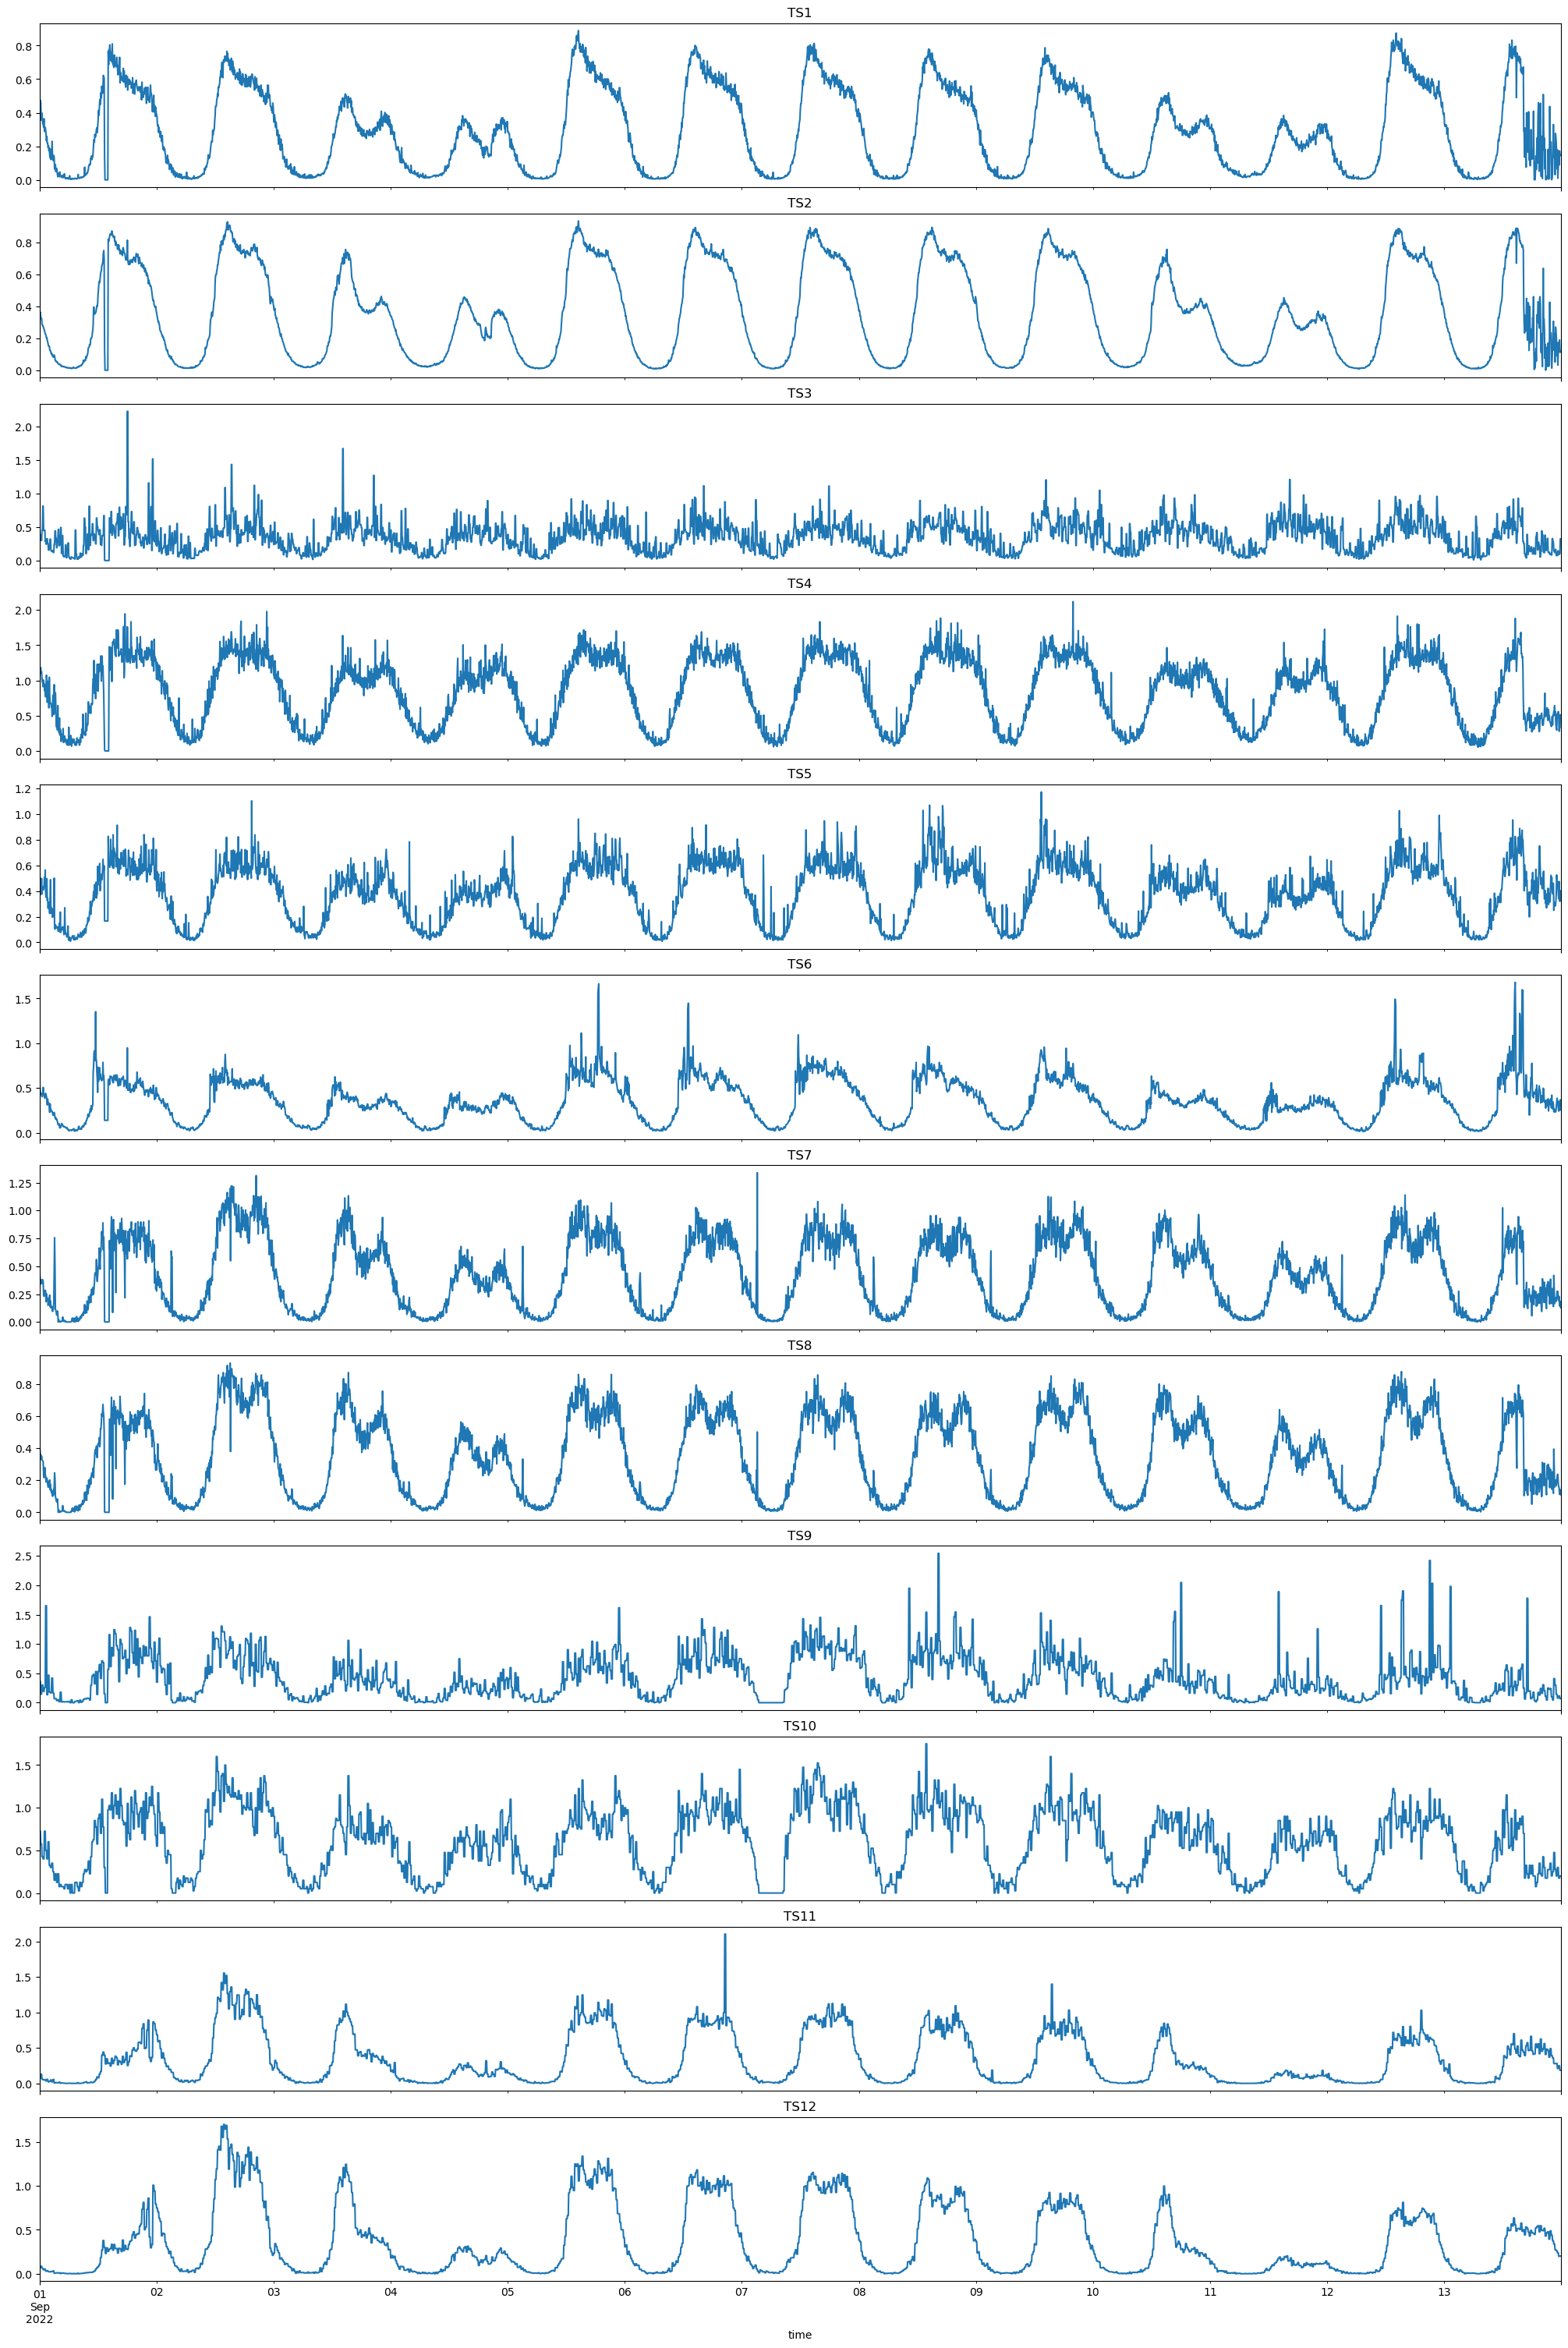

In [7]:
#define number of rows and columns for subplots
nrow=12
ncol=1

columns_list = data.columns

time_start = '2022-09-01'
time_end = '2022-09-13'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].set_title(columns_list[count])
        count+=1

### Tada por task

In [8]:
data_train_task1 = data[:'2022-02-28']
data_test_task1 = data['2022-03-01':'2022-03-31']

data_train_task2 = data['2022-04-01':'2022-05-31']
data_test_task2 = data['2022-06-01':'2022-06-30']

data_train_task3 = data['2022-07-01':'2022-08-31']
data_test_task3 = data['2022-09-01':'2022-09-12']

### CD

In [9]:
data_train_task1.shape

(16992, 12)

In [10]:
for col in data.columns:
    data_train_task1[col] = ((1 + np.sin(data_train_task1.index.hour / 2 * 2 * np.pi))/2 + data_train_task1[col])/2
    data_test_task1[col] = ((1 + np.sin(data_test_task1.index.hour / 2 * 2 * np.pi))/2 + data_test_task1[col])/2

    data_train_task2[col] = ((1 + np.sin(data_train_task2.index.hour / 24 * 2 * np.pi))/2 + data_train_task2[col])/2 
    data_test_task2[col] = ((1 + np.sin(data_test_task2.index.hour / 24 * 2 * np.pi))/2 + data_test_task2[col])/2  

    data_train_task3[col] = ((1 + np.sin(data_train_task3.index.minute / 60 * 2 * np.pi))/2 + data_train_task3[col])/2  
    data_test_task3[col] = ((1 + np.sin(data_test_task3.index.minute / 60 * 2 * np.pi))/2 + data_test_task3[col])/2   

/tmp/ipykernel_544506/2844492143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_task1[col] = ((1 + np.sin(data_train_task1.index.hour / 2 * 2 * np.pi))/2 + data_train_task1[col])/2
/tmp/ipykernel_544506/2844492143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_task1[col] = ((1 + np.sin(data_test_task1.index.hour / 2 * 2 * np.pi))/2 + data_test_task1[col])/2
/tmp/ipykernel_544506/2844492143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [11]:
TS1_CD = pd.concat([data_train, data_train_task1, data_test_task1, data_train_task2, data_test_task2, 
    data_train_task3, data_test_task3])

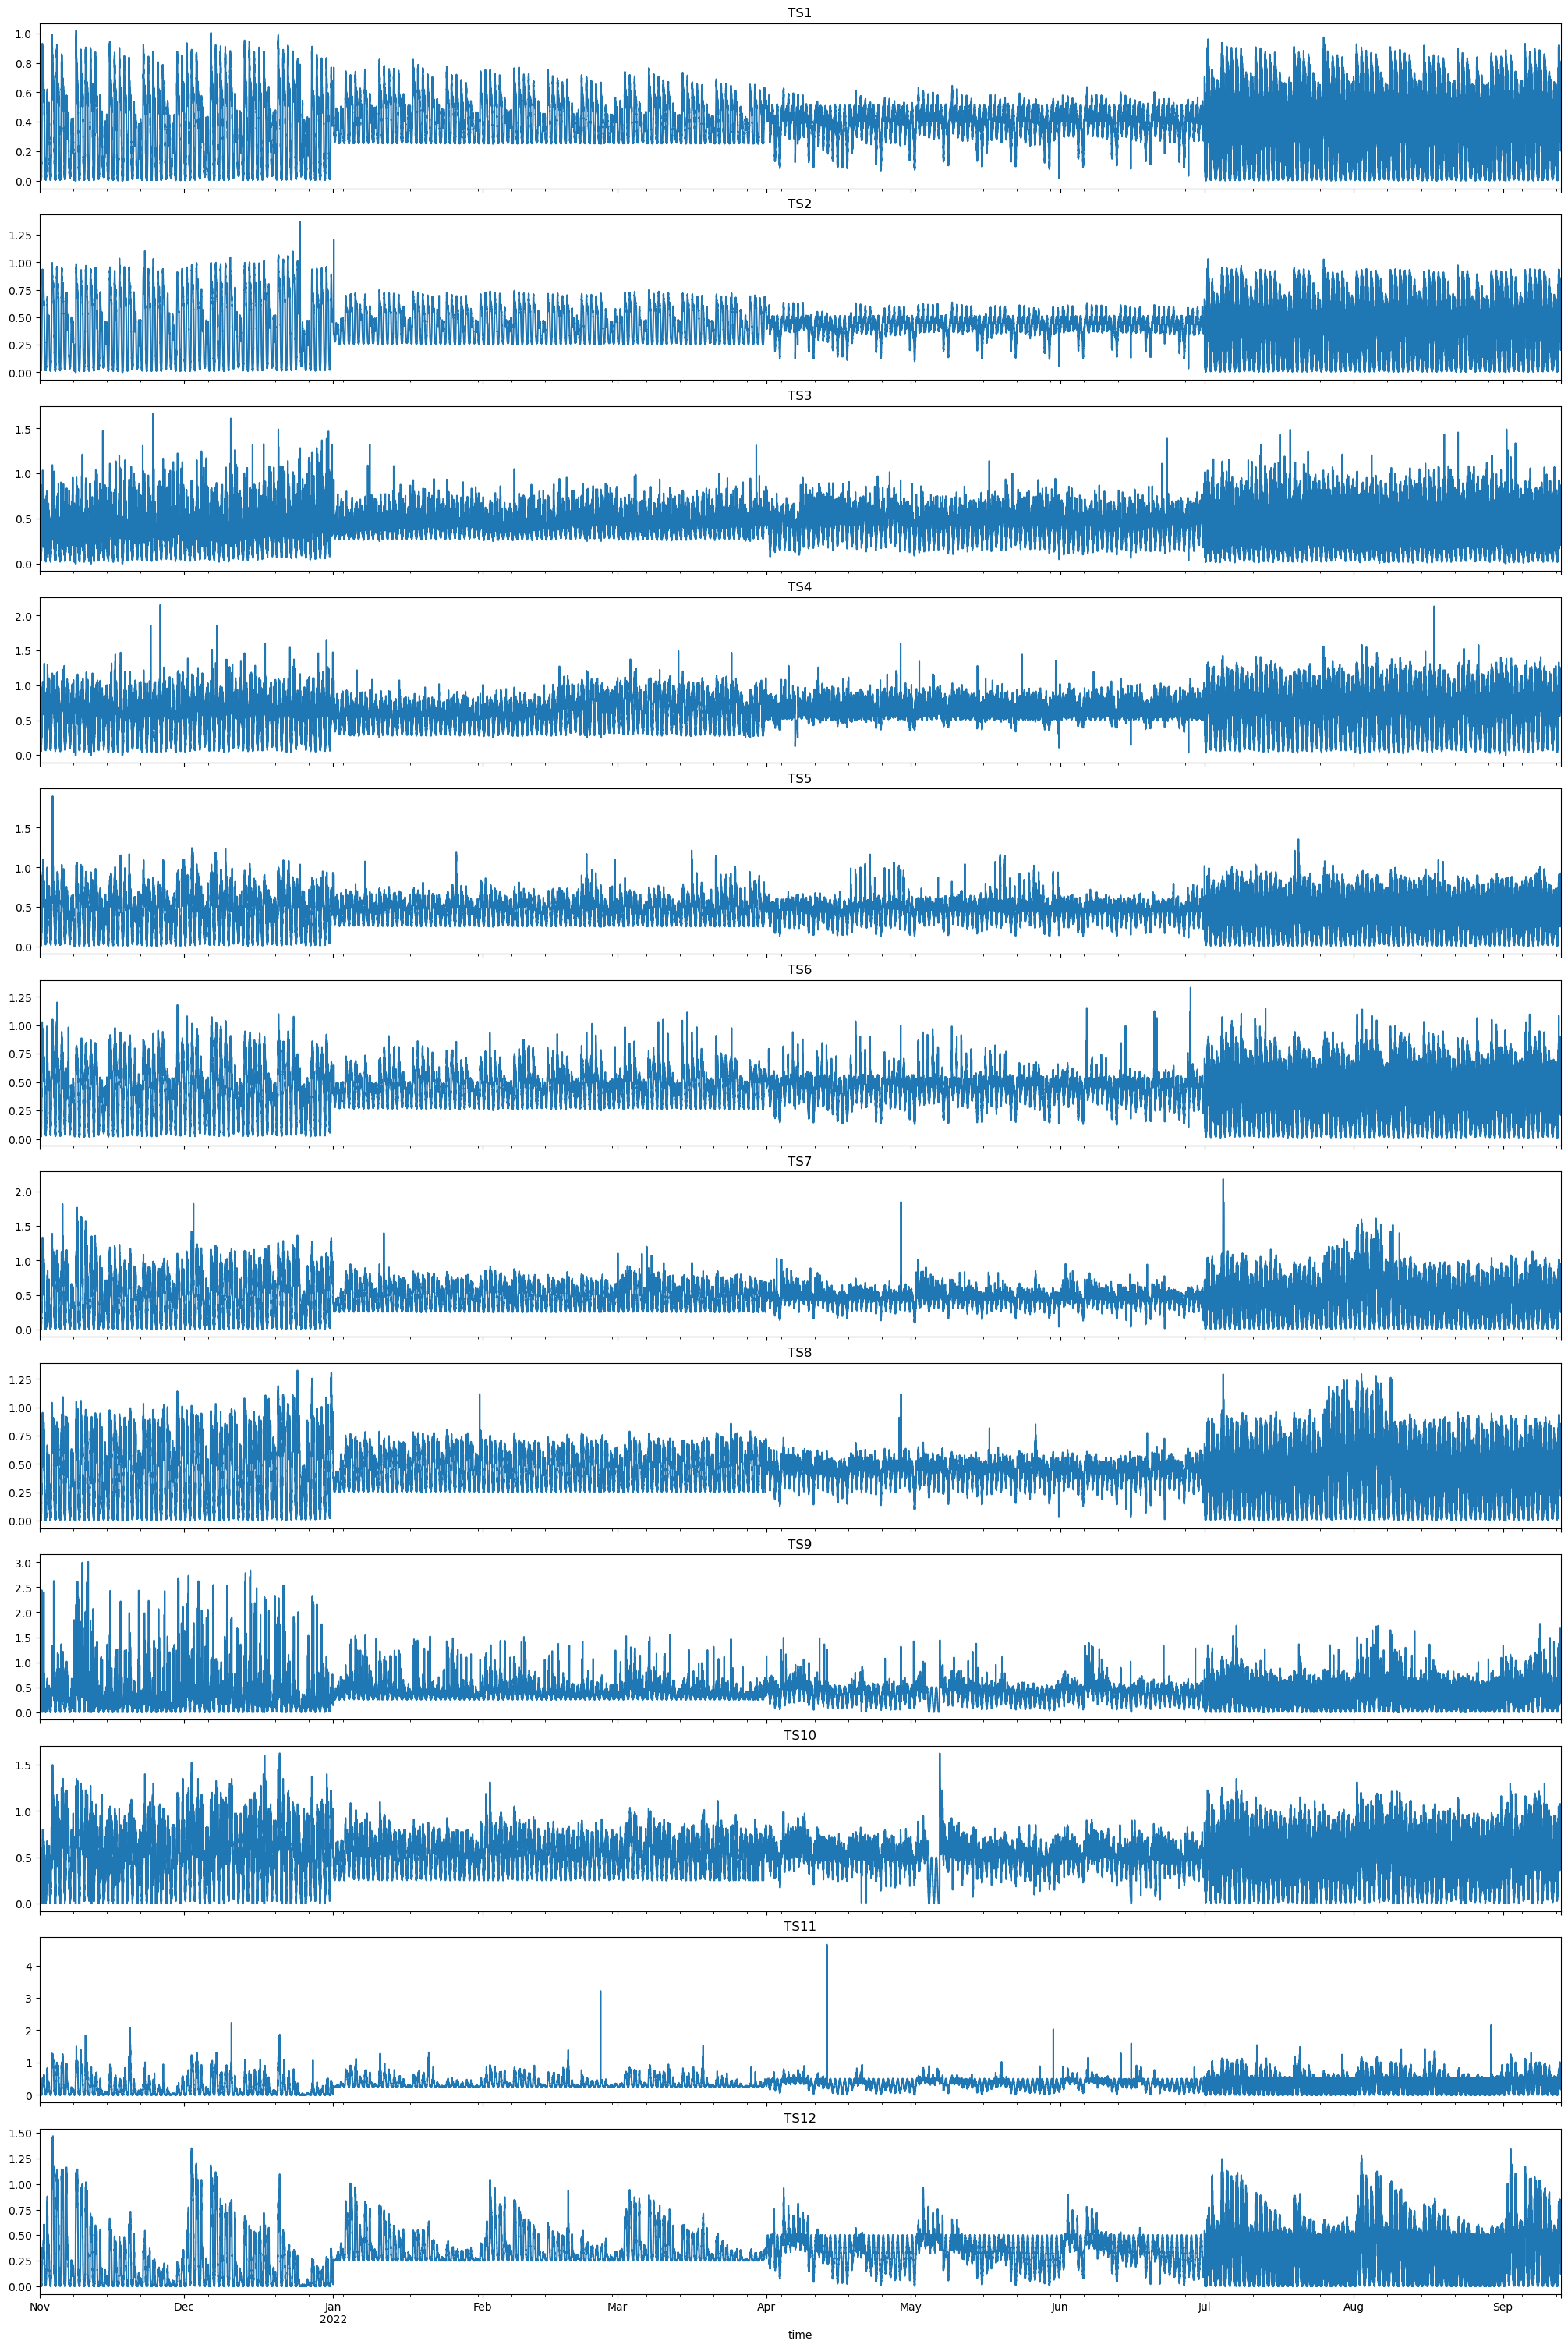

In [12]:
#define number of rows and columns for subplots
nrow=12
ncol=1

columns_list = data.columns

time_start = '2021-11-01'
time_end = '2022-09-13'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        TS1_CD[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].set_title(columns_list[count])
        count+=1

## Task1

In [13]:
# Model initialization
model_task1 = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['time_embedding'],
    settings['summary'],
    ) 

model_task1.vae = keras.models.load_model(settings['model_name']+'_complete.h5',
                                        custom_objects={'sampling': Sampling},
                                        compile = True)

# Compilation
opt = optimizers.Adam(learning_rate=settings['lr'])
model_task1.vae.compile(optimizer=opt)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-06-16 18:24:59.816444: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-16 18:24:59.817385: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-16 18:24:59.828218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 18:24:59.828338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-06-16 18:24:59.828358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-16 18:24:59.829526: I tensorflow/stream_executor/platform/default/d

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]        

In [14]:
model_task1.fit(data_train_task1,
    settings['val_percent'],
    settings['epochs'],
    settings['model_name']+'_task1',
    settings['save_best_model'],
    False)

2023-06-16 18:25:01.206861: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-16 18:25:01.207141: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/200


2023-06-16 18:25:02.571110: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-16 18:25:03.111972: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-06-16 18:25:03.192277: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-06-16 18:25:03.936660: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


422/422 [==============================] - 73s 103ms/step - loss: -2.3520 - reconst: -2.6451 - kl: 0.0058 - val_loss: -2.8633 - val_reconst: -2.8634 - val_kl: 9.2049e-05
Epoch 2/200
422/422 [==============================] - 6s 15ms/step - loss: -2.8804 - reconst: -2.8964 - kl: 5.9104e-05 - val_loss: -2.9355 - val_reconst: -2.9355 - val_kl: 3.8772e-05
Epoch 3/200
422/422 [==============================] - 6s 15ms/step - loss: -2.9321 - reconst: -2.9432 - kl: 3.0141e-05 - val_loss: -2.9694 - val_reconst: -2.9694 - val_kl: 2.3655e-05
Epoch 4/200
422/422 [==============================] - 6s 15ms/step - loss: -2.9634 - reconst: -2.9677 - kl: 1.9827e-05 - val_loss: -2.9091 - val_reconst: -2.9091 - val_kl: 1.7624e-05
Epoch 5/200
422/422 [==============================] - 6s 15ms/step - loss: -2.9866 - reconst: -2.9883 - kl: 1.4115e-05 - val_loss: -3.0059 - val_reconst: -3.0059 - val_kl: 1.2811e-05
Epoch 6/200
422/422 [==============================] - 6s 15ms/step - loss: -2.9954 - reconst:

### Data 0 Task 1

In [15]:
_, _, reconst_data0_task1, sig_data0_task1, _ = model_task1.predict(data_train,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task1'
                                                    )

/home/gastong/Documentos/DC-VAE/dc_vae_continual.py:313: RuntimeWarning: overflow encountered in exp
  sig_predict = np.sqrt(np.exp(prediction[1]))


<AxesSubplot:>

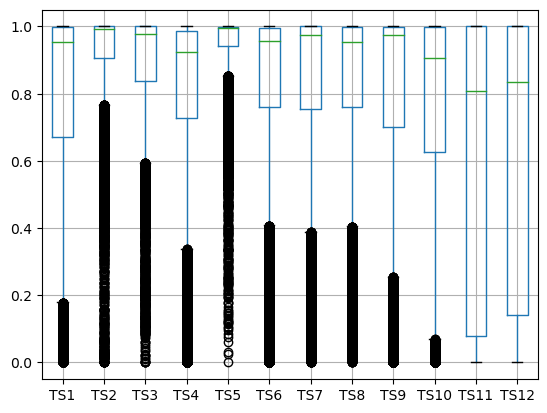

In [16]:
likelihood_data0_task1 = likelihood_norm(data_train[settings['T']-1:], reconst_data0_task1, sig_data0_task1)
likelihood_data0_task1.boxplot()

(0.8, 1.02)

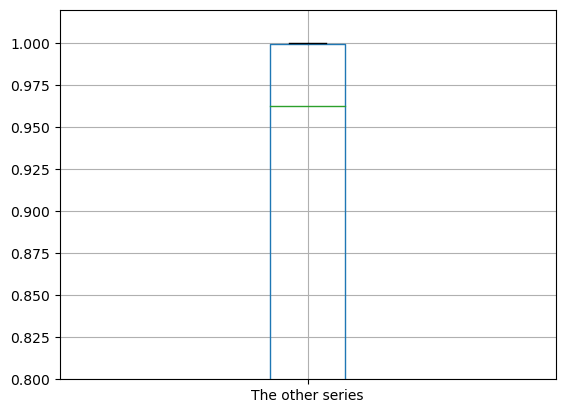

In [17]:
likelihood_data0_task1_rest = pd.concat([likelihood_data0_task1[col] for col in likelihood_data0_task1.columns[1:]], axis=0, ignore_index=True)
likelihood_data0_task1_rest = pd.DataFrame(likelihood_data0_task1_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data0_task1_rest.boxplot()


<AxesSubplot:>

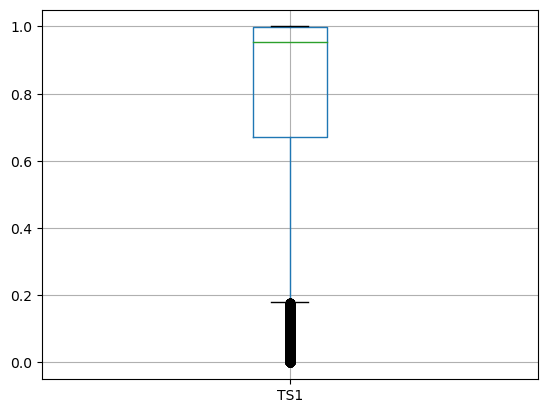

In [18]:
likelihood_data0_task1.boxplot(column=['TS1'])

### Data 1 Task 1

In [19]:
_, _, reconst_data1_task1, sig_data1_task1, _ = model_task1.predict(data_test_task1,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task1'
                                                    )

<AxesSubplot:>

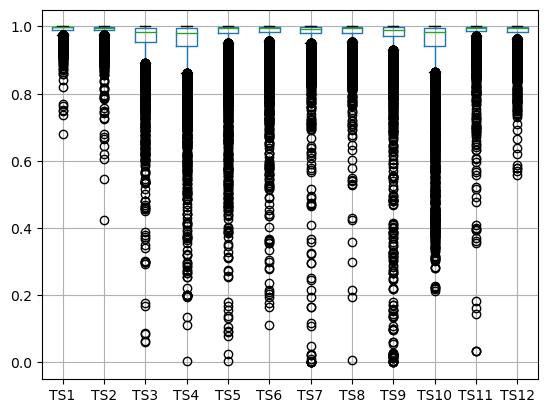

In [20]:
likelihood_data1_task1 = likelihood_norm(data_test_task1[settings['T']-1:], reconst_data1_task1, sig_data1_task1)
likelihood_data1_task1.boxplot()

(0.8, 1.02)

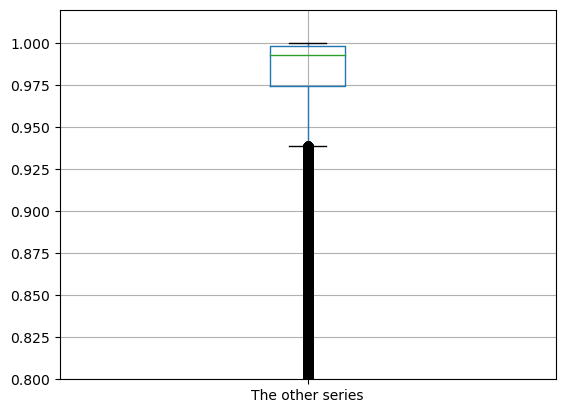

In [21]:
likelihood_data1_task1_rest = pd.concat([likelihood_data1_task1[col] for col in likelihood_data1_task1.columns[1:]], axis=0, ignore_index=True)
likelihood_data1_task1_rest = pd.DataFrame(likelihood_data1_task1_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data1_task1_rest.boxplot()
plt.ylim([0.80, 1.02])

([<matplotlib.axis.XTick at 0x7fa5d40d8be0>,
 [Text(1, 0, 'data0_task1'), Text(2, 0, 'data1_task1')])

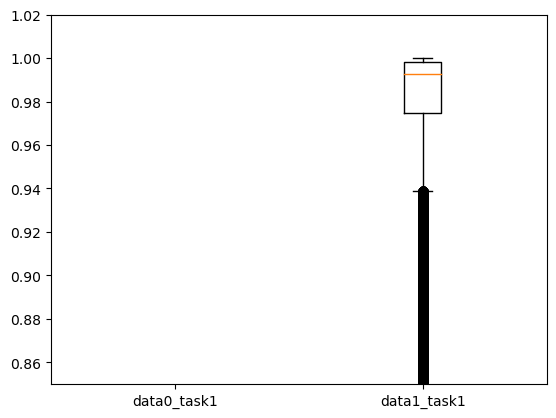

In [22]:
plt.boxplot([likelihood_data0_task1_rest.values[:,0], likelihood_data1_task1_rest.values[:,0]])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2], ['data0_task1', 'data1_task1'])

## Task 2

In [23]:
# Model initialization
model_task2 = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['time_embedding'],
    settings['summary'],
    ) 

model_task2.vae = clone_model(model_task1.vae)


# Compilation
opt = optimizers.Adam(learning_rate=settings['lr'])
model_task2.vae.compile(optimizer=opt)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 128)     32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [24]:
model_task2.fit(data_train_task2,
    settings['val_percent'],
    settings['epochs'],
    settings['model_name']+'_task2',
    settings['save_best_model'],
    False)

Epoch 1/200
436/436 [==============================] - 8s 16ms/step - loss: 0.8991 - reconst: -0.2667 - kl: 0.0127 - val_loss: -1.3580 - val_reconst: -1.3605 - val_kl: 0.0024
Epoch 2/200
436/436 [==============================] - 7s 15ms/step - loss: -1.5151 - reconst: -1.6383 - kl: 0.0016 - val_loss: -1.8384 - val_reconst: -1.8395 - val_kl: 0.0011
Epoch 3/200
436/436 [==============================] - 7s 15ms/step - loss: -1.8644 - reconst: -1.9124 - kl: 8.8862e-04 - val_loss: -2.0054 - val_reconst: -2.0062 - val_kl: 7.8273e-04
Epoch 4/200
436/436 [==============================] - 7s 15ms/step - loss: -2.0214 - reconst: -2.0493 - kl: 5.8290e-04 - val_loss: -2.0875 - val_reconst: -2.0881 - val_kl: 5.3604e-04
Epoch 5/200
436/436 [==============================] - 7s 15ms/step - loss: -2.1193 - reconst: -2.1363 - kl: 4.0974e-04 - val_loss: -2.1797 - val_reconst: -2.1800 - val_kl: 3.3832e-04
Epoch 6/200
436/436 [==============================] - 7s 15ms/step - loss: -2.1915 - reconst: -2

### Data 0 Task 2

In [25]:
_, _, reconst_data0_task2, sig_data0_task2, _ = model_task2.predict(data_train,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task2'
                                                    )

<AxesSubplot:>

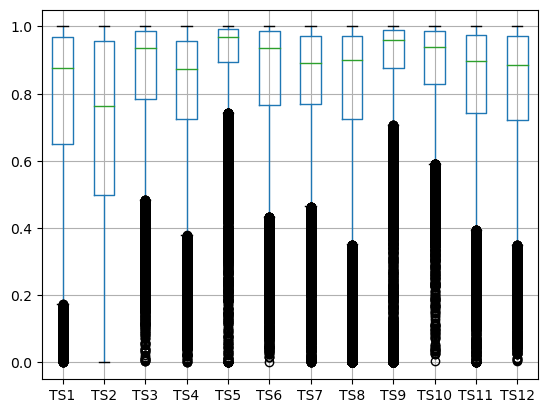

In [26]:
likelihood_data0_task2 = likelihood_norm(data_train[settings['T']-1:], reconst_data0_task2, sig_data0_task2)
likelihood_data0_task2.boxplot()

(0.8, 1.02)

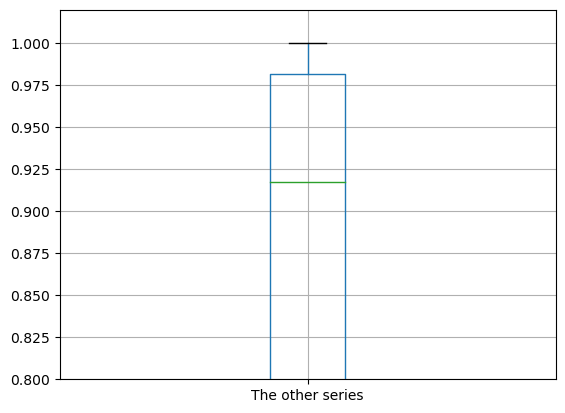

In [27]:
likelihood_data0_task2_rest = pd.concat([likelihood_data0_task2[col] for col in likelihood_data0_task2.columns[1:]], axis=0, ignore_index=True)
likelihood_data0_task2_rest = pd.DataFrame(likelihood_data0_task2_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data0_task2_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 1 Task 2

In [28]:
_, _, reconst_data1_task2, sig_data1_task2, _ = model_task2.predict(data_test_task1,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task2'
                                                    )

<AxesSubplot:>

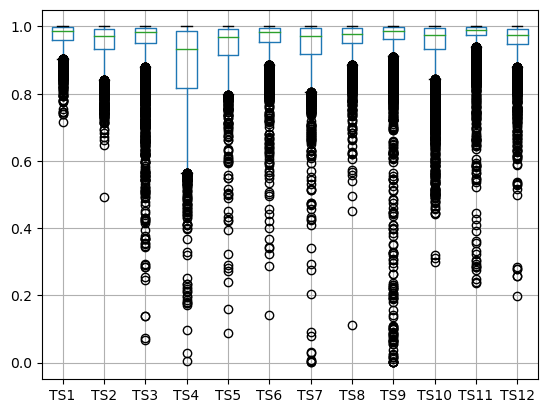

In [29]:
likelihood_data1_task2 = likelihood_norm(data_test_task1[settings['T']-1:], reconst_data1_task2, sig_data1_task2)
likelihood_data1_task2.boxplot()

(0.8, 1.02)

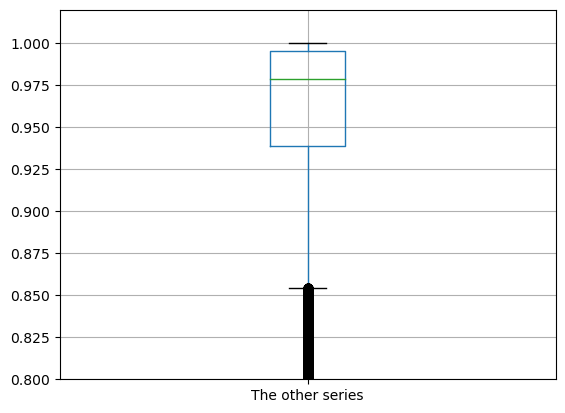

In [30]:
likelihood_data1_task2_rest = pd.concat([likelihood_data1_task2[col] for col in likelihood_data1_task2.columns[1:]], axis=0, ignore_index=True)
likelihood_data1_task2_rest = pd.DataFrame(likelihood_data1_task2_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data1_task2_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 2 Task 2

In [31]:
_, _, reconst_data2_task2, sig_data2_task2, _ = model_task2.predict(data_test_task2,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task2'
                                                    )

<AxesSubplot:>

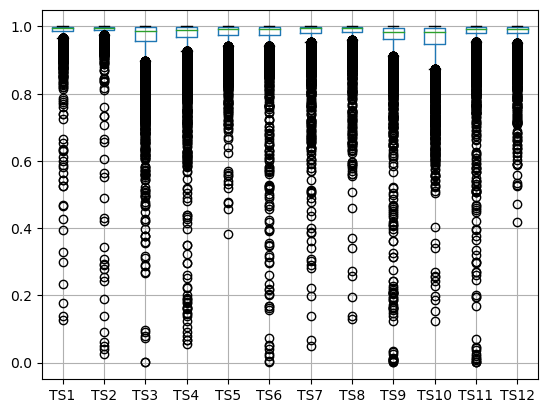

In [32]:
likelihood_data2_task2 = likelihood_norm(data_test_task2[settings['T']-1:], reconst_data2_task2, sig_data2_task2)
likelihood_data2_task2.boxplot()

(0.8, 1.02)

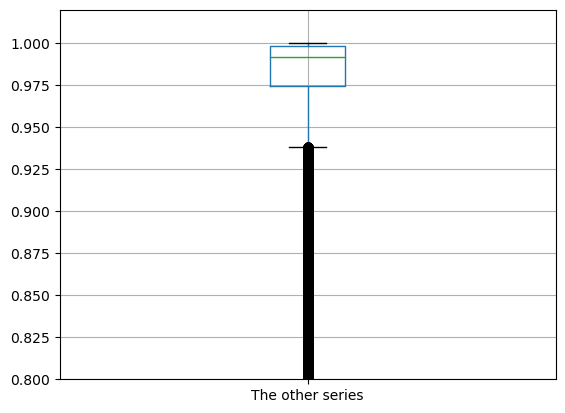

In [33]:
likelihood_data2_task2_rest = pd.concat([likelihood_data2_task2[col] for col in likelihood_data2_task2.columns[1:]], axis=0, ignore_index=True)
likelihood_data2_task2_rest = pd.DataFrame(likelihood_data2_task2_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data2_task2_rest.boxplot()
plt.ylim([0.80, 1.02])

([<matplotlib.axis.XTick at 0x7fa5681a6f40>,
 [Text(1, 0, 'data0_task2'),
  Text(2, 0, 'data1_task2'),
  Text(3, 0, 'data2_task2')])

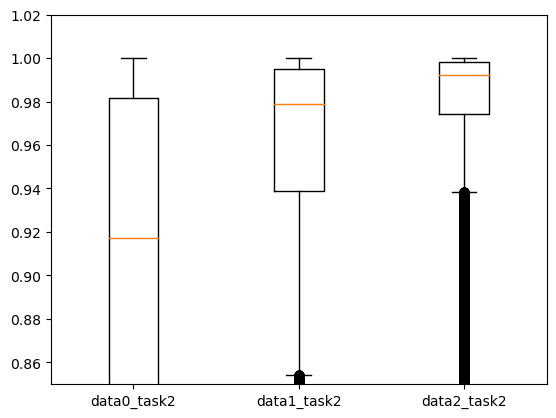

In [34]:
plt.boxplot([likelihood_data0_task2_rest.values[:,0], likelihood_data1_task2_rest.values[:,0], likelihood_data2_task2_rest.values[:,0]])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2, 3], ['data0_task2', 'data1_task2', 'data2_task2'])

([<matplotlib.axis.XTick at 0x7fa5681358e0>,
 [Text(1, 0, 'data0_task2'),
  Text(2, 0, 'data1_task2'),
  Text(3, 0, 'data2_task2')])

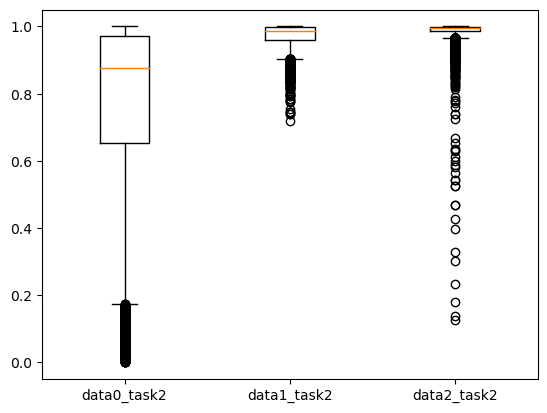

In [35]:
plt.boxplot([likelihood_data0_task2['TS1'].values, likelihood_data1_task2['TS1'].values, likelihood_data2_task2['TS1'].values])
plt.title('')
plt.xticks([1, 2, 3], ['data0_task2', 'data1_task2', 'data2_task2'])

## Task 3

In [36]:
# Model initialization
model_task3 = DCVAE(
    settings['T'],
    settings['M'],
    settings['cnn_units'],
    settings['dil_rate'],
    settings['kernel'],
    settings['strs'],
    settings['batch_size'],
    settings['J'],
    settings['lr'],
    settings['lr_decay'],
    settings['decay_rate'],
    settings['decay_step'],
    settings['time_embedding'],
    settings['summary'],
    ) 

model_task3.vae = clone_model(model_task2.vae)


# Compilation
opt = optimizers.Adam(learning_rate=settings['lr'])
model_task3.vae.compile(optimizer=opt)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_samples (InputLayer)      [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
dcnn_enc_0 (Conv1D)             (None, 128, 64)      1536        input_samples[0][0]              
__________________________________________________________________________________________________
dcnn_enc_1 (Conv1D)             (None, 128, 128)     16384       dcnn_enc_0[0][0]                 
__________________________________________________________________________________________________
dcnn_enc_2 (Conv1D)             (None, 128, 128)     32768       dcnn_enc_1[0][0]                 
____________________________________________________________________________________________

In [37]:
model_task3 = model_task2

In [38]:
model_task3.fit(data_train_task3,
    settings['val_percent'],
    settings['epochs'],
    settings['model_name']+'_task3',
    settings['save_best_model'],
    False)

Epoch 1/200
444/444 [==============================] - 54s 119ms/step - loss: -0.7949 - reconst: -0.7949 - kl: 1.3445e-05 - val_loss: -1.1052 - val_reconst: -1.1052 - val_kl: 5.5703e-06
Epoch 2/200
444/444 [==============================] - 7s 15ms/step - loss: -1.1270 - reconst: -1.1270 - kl: 5.5267e-06 - val_loss: -1.1425 - val_reconst: -1.1426 - val_kl: 5.1461e-06
Epoch 3/200
444/444 [==============================] - 7s 15ms/step - loss: -1.1587 - reconst: -1.1587 - kl: 5.3350e-06 - val_loss: -1.1794 - val_reconst: -1.1794 - val_kl: 5.1695e-06
Epoch 4/200
444/444 [==============================] - 7s 15ms/step - loss: -1.3514 - reconst: -1.3514 - kl: 5.0952e-06 - val_loss: -1.7689 - val_reconst: -1.7689 - val_kl: 9.3253e-06
Epoch 5/200
444/444 [==============================] - 7s 15ms/step - loss: -2.0955 - reconst: -2.0955 - kl: 4.8934e-06 - val_loss: -2.3176 - val_reconst: -2.3176 - val_kl: 5.1470e-06
Epoch 6/200
444/444 [==============================] - 7s 15ms/step - loss: -2

### Data 0 Task 3

In [39]:
_, _, reconst_data0_task3, sig_data0_task3, _ = model_task3.predict(data_train,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

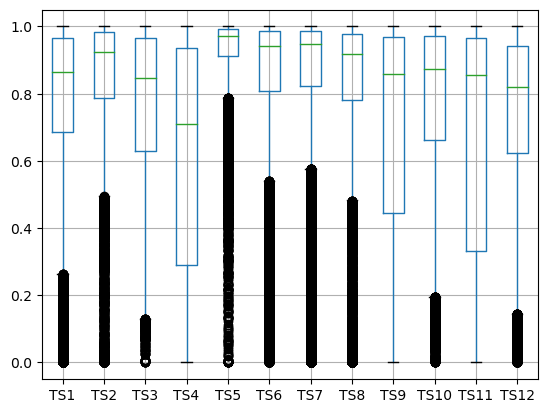

In [40]:
likelihood_data0_task3 = likelihood_norm(data_train[settings['T']-1:], reconst_data0_task3, sig_data0_task3)
likelihood_data0_task3.boxplot()

(0.8, 1.02)

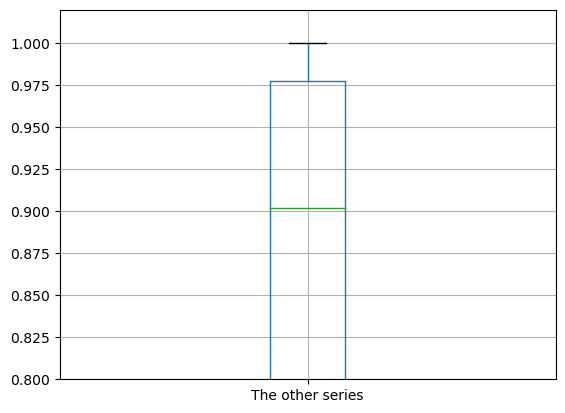

In [41]:
likelihood_data0_task3_rest = pd.concat([likelihood_data0_task3[col] for col in likelihood_data0_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data0_task3_rest = pd.DataFrame(likelihood_data0_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data0_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 1 Task 3

In [42]:
_, _, reconst_data1_task3, sig_data1_task3, _ = model_task3.predict(data_test_task1,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

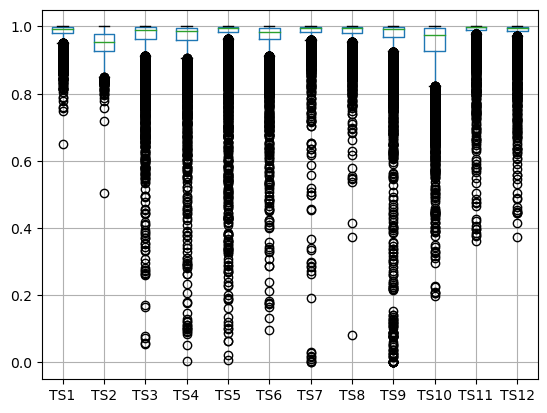

In [43]:
likelihood_data1_task3 = likelihood_norm(data_test_task1[settings['T']-1:], reconst_data1_task3, sig_data1_task3)
likelihood_data1_task3.boxplot()

(0.8, 1.02)

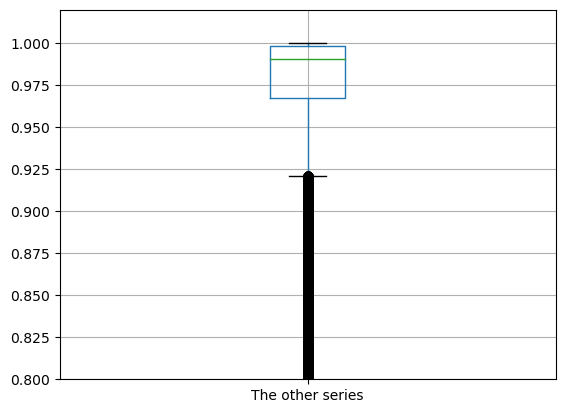

In [44]:
likelihood_data1_task3_rest = pd.concat([likelihood_data1_task3[col] for col in likelihood_data1_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data1_task3_rest = pd.DataFrame(likelihood_data1_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data1_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 2 Task 3

In [45]:
_, _, reconst_data2_task3, sig_data2_task3, _ = model_task3.predict(data_test_task2,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

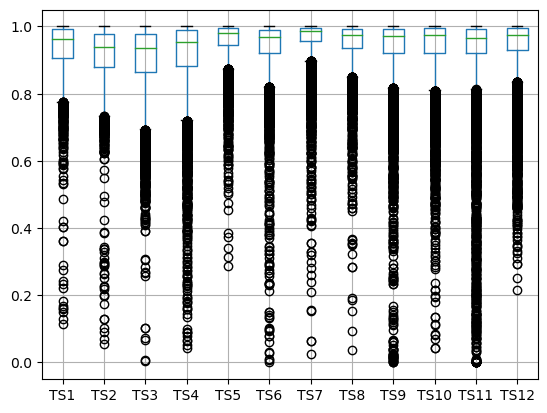

In [46]:
likelihood_data2_task3 = likelihood_norm(data_test_task2[settings['T']-1:], reconst_data2_task3, sig_data2_task3)
likelihood_data2_task3.boxplot()

(0.8, 1.02)

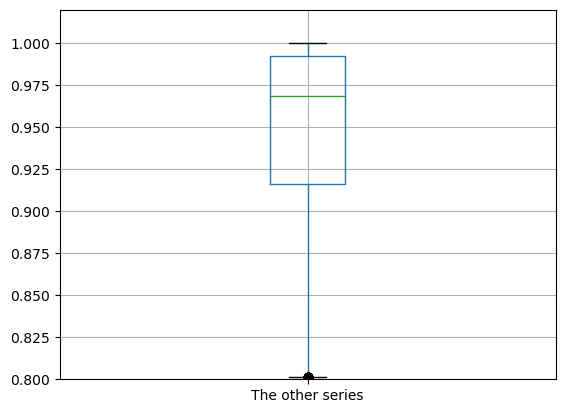

In [47]:
likelihood_data2_task3_rest = pd.concat([likelihood_data2_task3[col] for col in likelihood_data2_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data2_task3_rest = pd.DataFrame(likelihood_data2_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data2_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

### Data 3 Task 3

In [48]:
_, _, reconst_data3_task3, sig_data3_task3, _ = model_task3.predict(data_test_task3,
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

<AxesSubplot:>

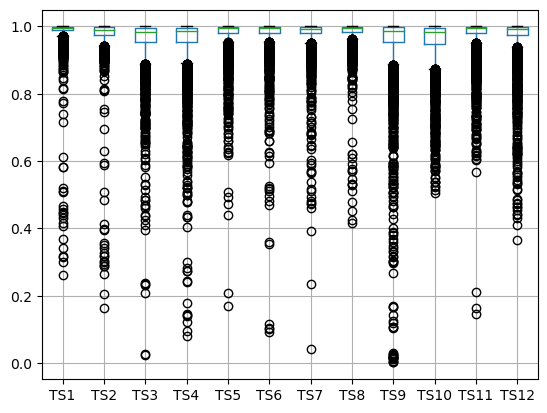

In [49]:
likelihood_data3_task3 = likelihood_norm(data_test_task3[settings['T']-1:], reconst_data3_task3, sig_data3_task3)
likelihood_data3_task3.boxplot()

(0.8, 1.02)

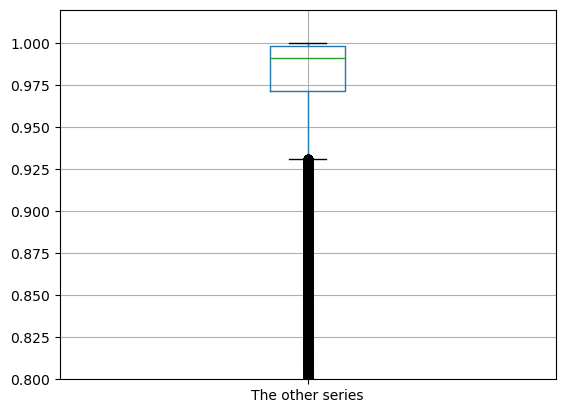

In [50]:
likelihood_data3_task3_rest = pd.concat([likelihood_data3_task3[col] for col in likelihood_data3_task3.columns[1:]], axis=0, ignore_index=True)
likelihood_data3_task3_rest = pd.DataFrame(likelihood_data3_task3_rest, columns=['The other series'])  # You can change 'New Column Name' to your desired column name

likelihood_data3_task3_rest.boxplot()
plt.ylim([0.80, 1.02])

([<matplotlib.axis.XTick at 0x7fa2a7709730>,
 [Text(1, 0, 'data0_task3'),
  Text(2, 0, 'data1_task3'),
  Text(3, 0, 'data2_task3'),
  Text(4, 0, 'data3_task3')])

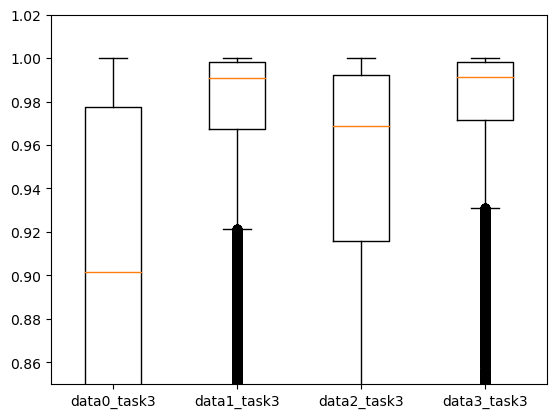

In [51]:
plt.boxplot([likelihood_data0_task3_rest.values[:,0], likelihood_data1_task3_rest.values[:,0], likelihood_data2_task3_rest.values[:,0], likelihood_data3_task3_rest.values[:,0]])
plt.ylim([0.85, 1.02])
plt.title('')
plt.xticks([1, 2, 3, 4], ['data0_task3', 'data1_task3', 'data2_task3', 'data3_task3'])

([<matplotlib.axis.XTick at 0x7fa2a7629f70>,
 [Text(1, 0, 'data0_task3'),
  Text(2, 0, 'data1_task3'),
  Text(3, 0, 'data2_task3'),
  Text(4, 0, 'data3_task3')])

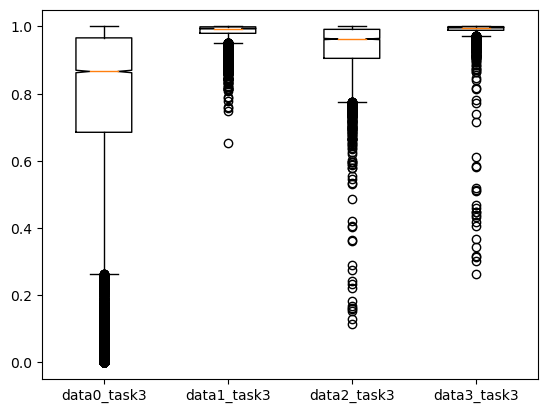

In [52]:
plt.boxplot([likelihood_data0_task3['TS1'].values, likelihood_data1_task3['TS1'].values, likelihood_data2_task3['TS1'].values, likelihood_data3_task3['TS1'].values],
 notch=True,
 bootstrap=5000)
plt.title('')
plt.xticks([1, 2, 3, 4], ['data0_task3', 'data1_task3', 'data2_task3', 'data3_task3'])

In [53]:
likelihood_data0_task3['TS1'].shape

(17441,)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa2a72d6610>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa2a72d6bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa2a72d6340>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa2a72631f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa2a7263520>],
 'means': []}

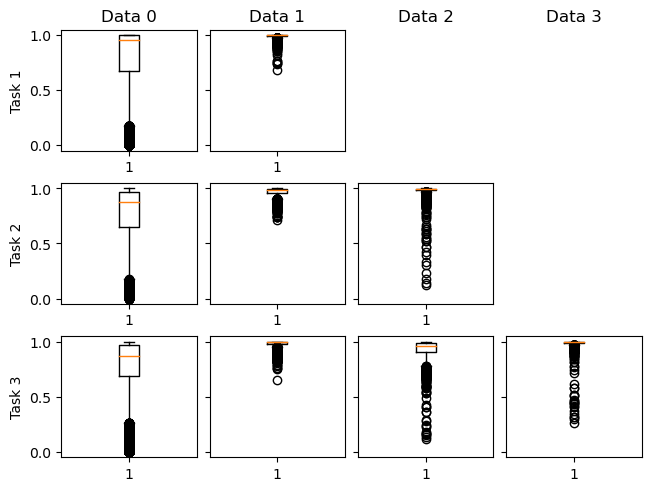

In [54]:
#define number of rows and columns for subplots
nrow=3
ncol=4

fig, axes = plt.subplots(nrow, ncol, constrained_layout=True, sharey=True)

axes[0,0].boxplot(likelihood_data0_task1['TS1'].values)
axes[0,0].set_title('Data 0')
axes[0,0].set_ylabel('Task 1')
axes[0,1].boxplot(likelihood_data1_task1['TS1'].values)
axes[0,1].set_title('Data 1')
axes[0,2].axis('off')
axes[0,2].set_title('Data 2')
axes[0,3].axis('off')
axes[0,3].set_title('Data 3')


axes[1,0].boxplot(likelihood_data0_task2['TS1'].values)
axes[1,0].set_ylabel('Task 2')
axes[1,1].boxplot(likelihood_data1_task2['TS1'].values)
axes[1,2].boxplot(likelihood_data2_task2['TS1'].values)
axes[1,3].axis('off')

axes[2,0].boxplot(likelihood_data0_task3['TS1'].values)
axes[2,0].set_ylabel('Task 3')
axes[2,1].boxplot(likelihood_data1_task3['TS1'].values)
axes[2,2].boxplot(likelihood_data2_task3['TS1'].values)
axes[2,3].boxplot(likelihood_data3_task3['TS1'].values)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa2aaadf070>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa2a6ff95b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa2aaad6550>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa2a6ff9c70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa2a6ff9af0>],
 'means': []}

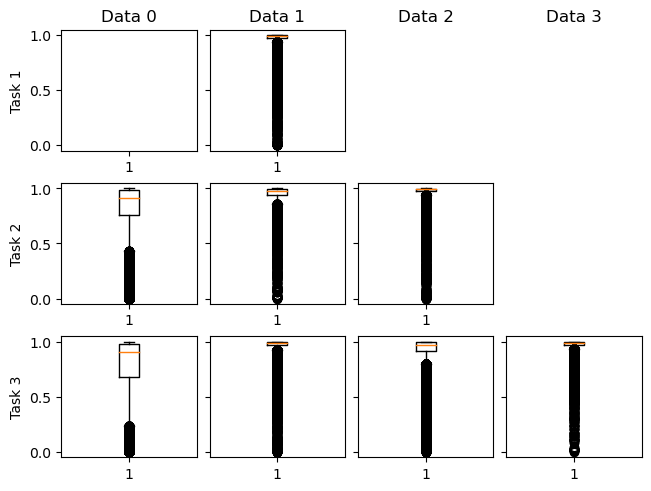

In [60]:
#define number of rows and columns for subplots
nrow=3
ncol=4

fig, axes = plt.subplots(nrow, ncol, constrained_layout=True, sharey=True)

axes[0,0].boxplot(likelihood_data0_task1_rest.values[:,0])
axes[0,0].set_title('Data 0')
axes[0,0].set_ylabel('Task 1')
axes[0,1].boxplot(likelihood_data1_task1_rest.values[:,0])
axes[0,1].set_title('Data 1')
axes[0,2].axis('off')
axes[0,2].set_title('Data 2')
axes[0,3].axis('off')
axes[0,3].set_title('Data 3')


axes[1,0].boxplot(likelihood_data0_task2_rest.values[:,0])
axes[1,0].set_ylabel('Task 2')
axes[1,1].boxplot(likelihood_data1_task2_rest.values[:,0])
axes[1,2].boxplot(likelihood_data2_task2_rest.values[:,0])
axes[1,3].axis('off')

axes[2,0].boxplot(likelihood_data0_task3_rest.values[:,0])
axes[2,0].set_ylabel('Task 3')
axes[2,1].boxplot(likelihood_data1_task3_rest.values[:,0])
axes[2,2].boxplot(likelihood_data2_task3_rest.values[:,0])
axes[2,3].boxplot(likelihood_data3_task3_rest.values[:,0])




In [56]:
data_CD = pd.concat([data_train, data_train_task1, data_test_task1, data_train_task2, data_test_task2, 
    data_train_task3, data_test_task3])

In [57]:
_, _, reconst_CD, sig_CD, _ = model_task3.predict(data_CD['2021-11-01': '2021-12-31'],
                                        False,
                                        large_result=True,
                                        load_alpha=False,
                                        alpha_set_up = list(np.ones(12)),
                                        alpha_set_down = list(np.ones(12)),
                                        name=settings["model_name"]+'_task3'
                                                    )

In [58]:
th_up_CD = reconst_CD + sig_CD
th_down_CD = reconst_CD - sig_CD

ValueError: operands could not be broadcast together with shapes (90305,) (17441,) 

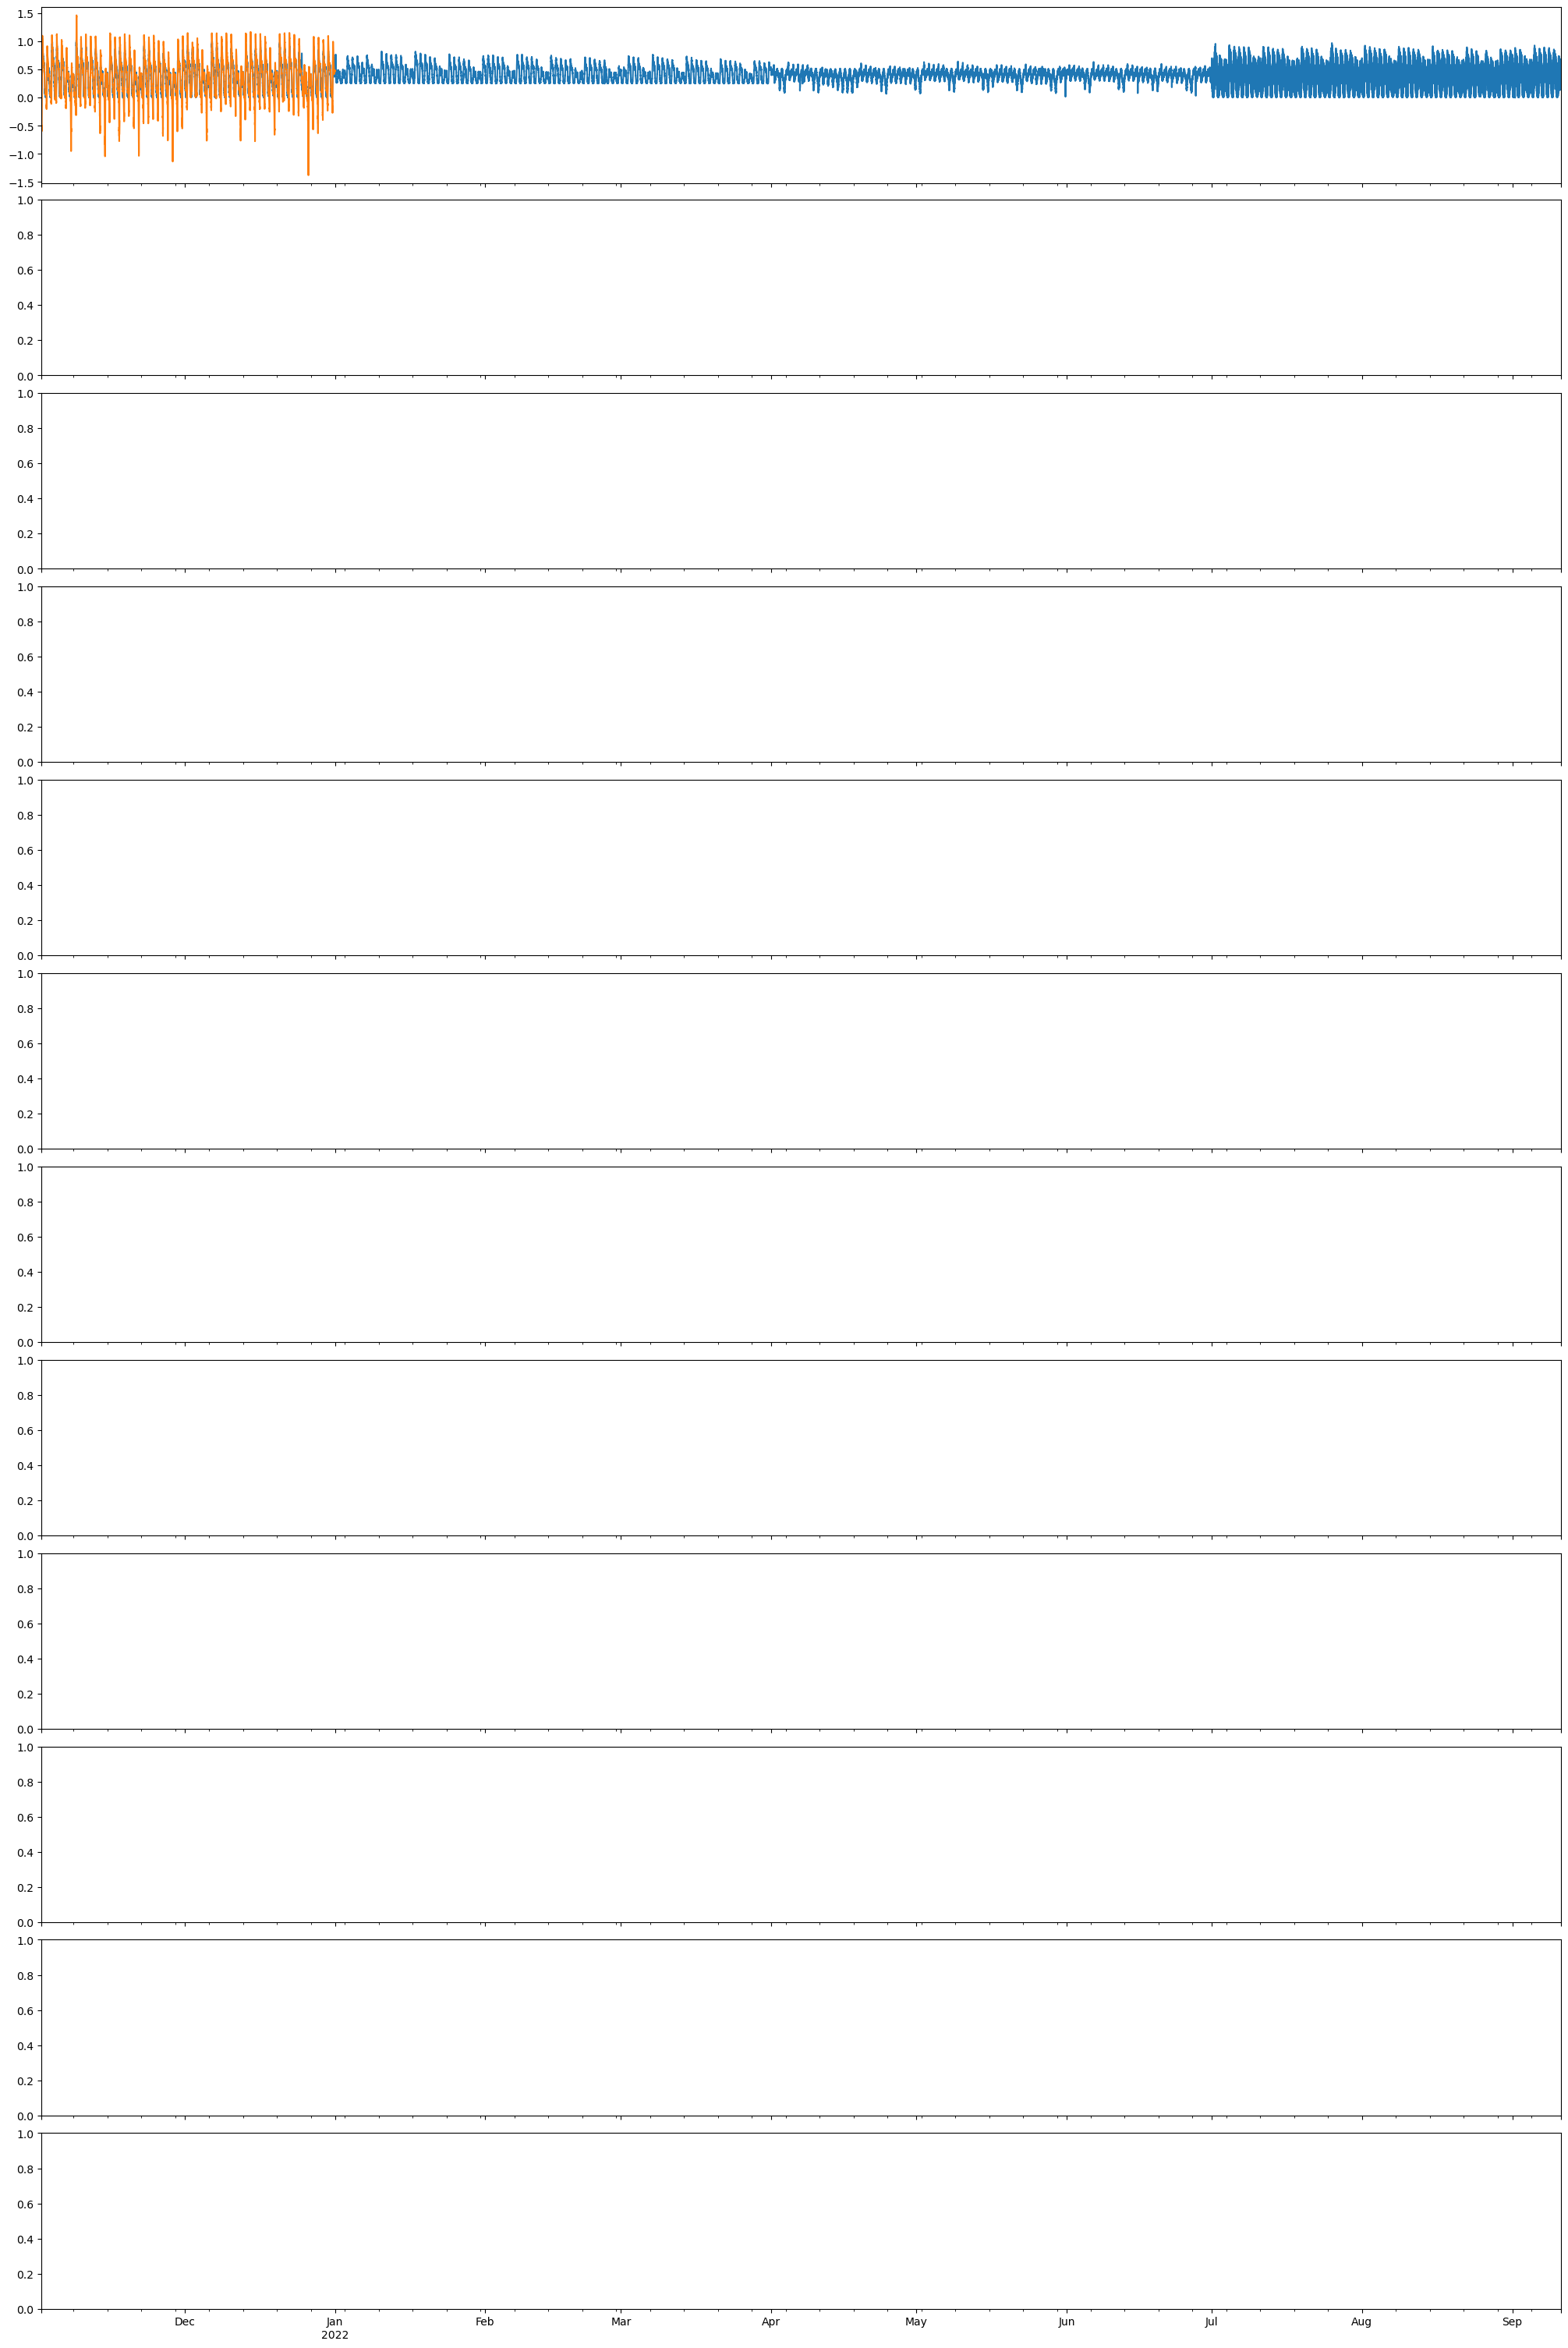

In [59]:
#define number of rows and columns for subplots
nrow=12
ncol=1
data_aux = data_CD[reconst_CD.index[0]:].copy()

columns_list = data_aux.columns

time_start = '2021-11-01'
time_end = '2022-09-10'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_aux[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        reconst_CD[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].fill_between(data_aux[columns_list[count]][time_start:time_end].index,
                         th_up_CD[columns_list[count]][time_start:time_end],
                         th_down_CD[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.6, interpolate=True)
        axes[r].set_title(columns_list[count])
        count+=1

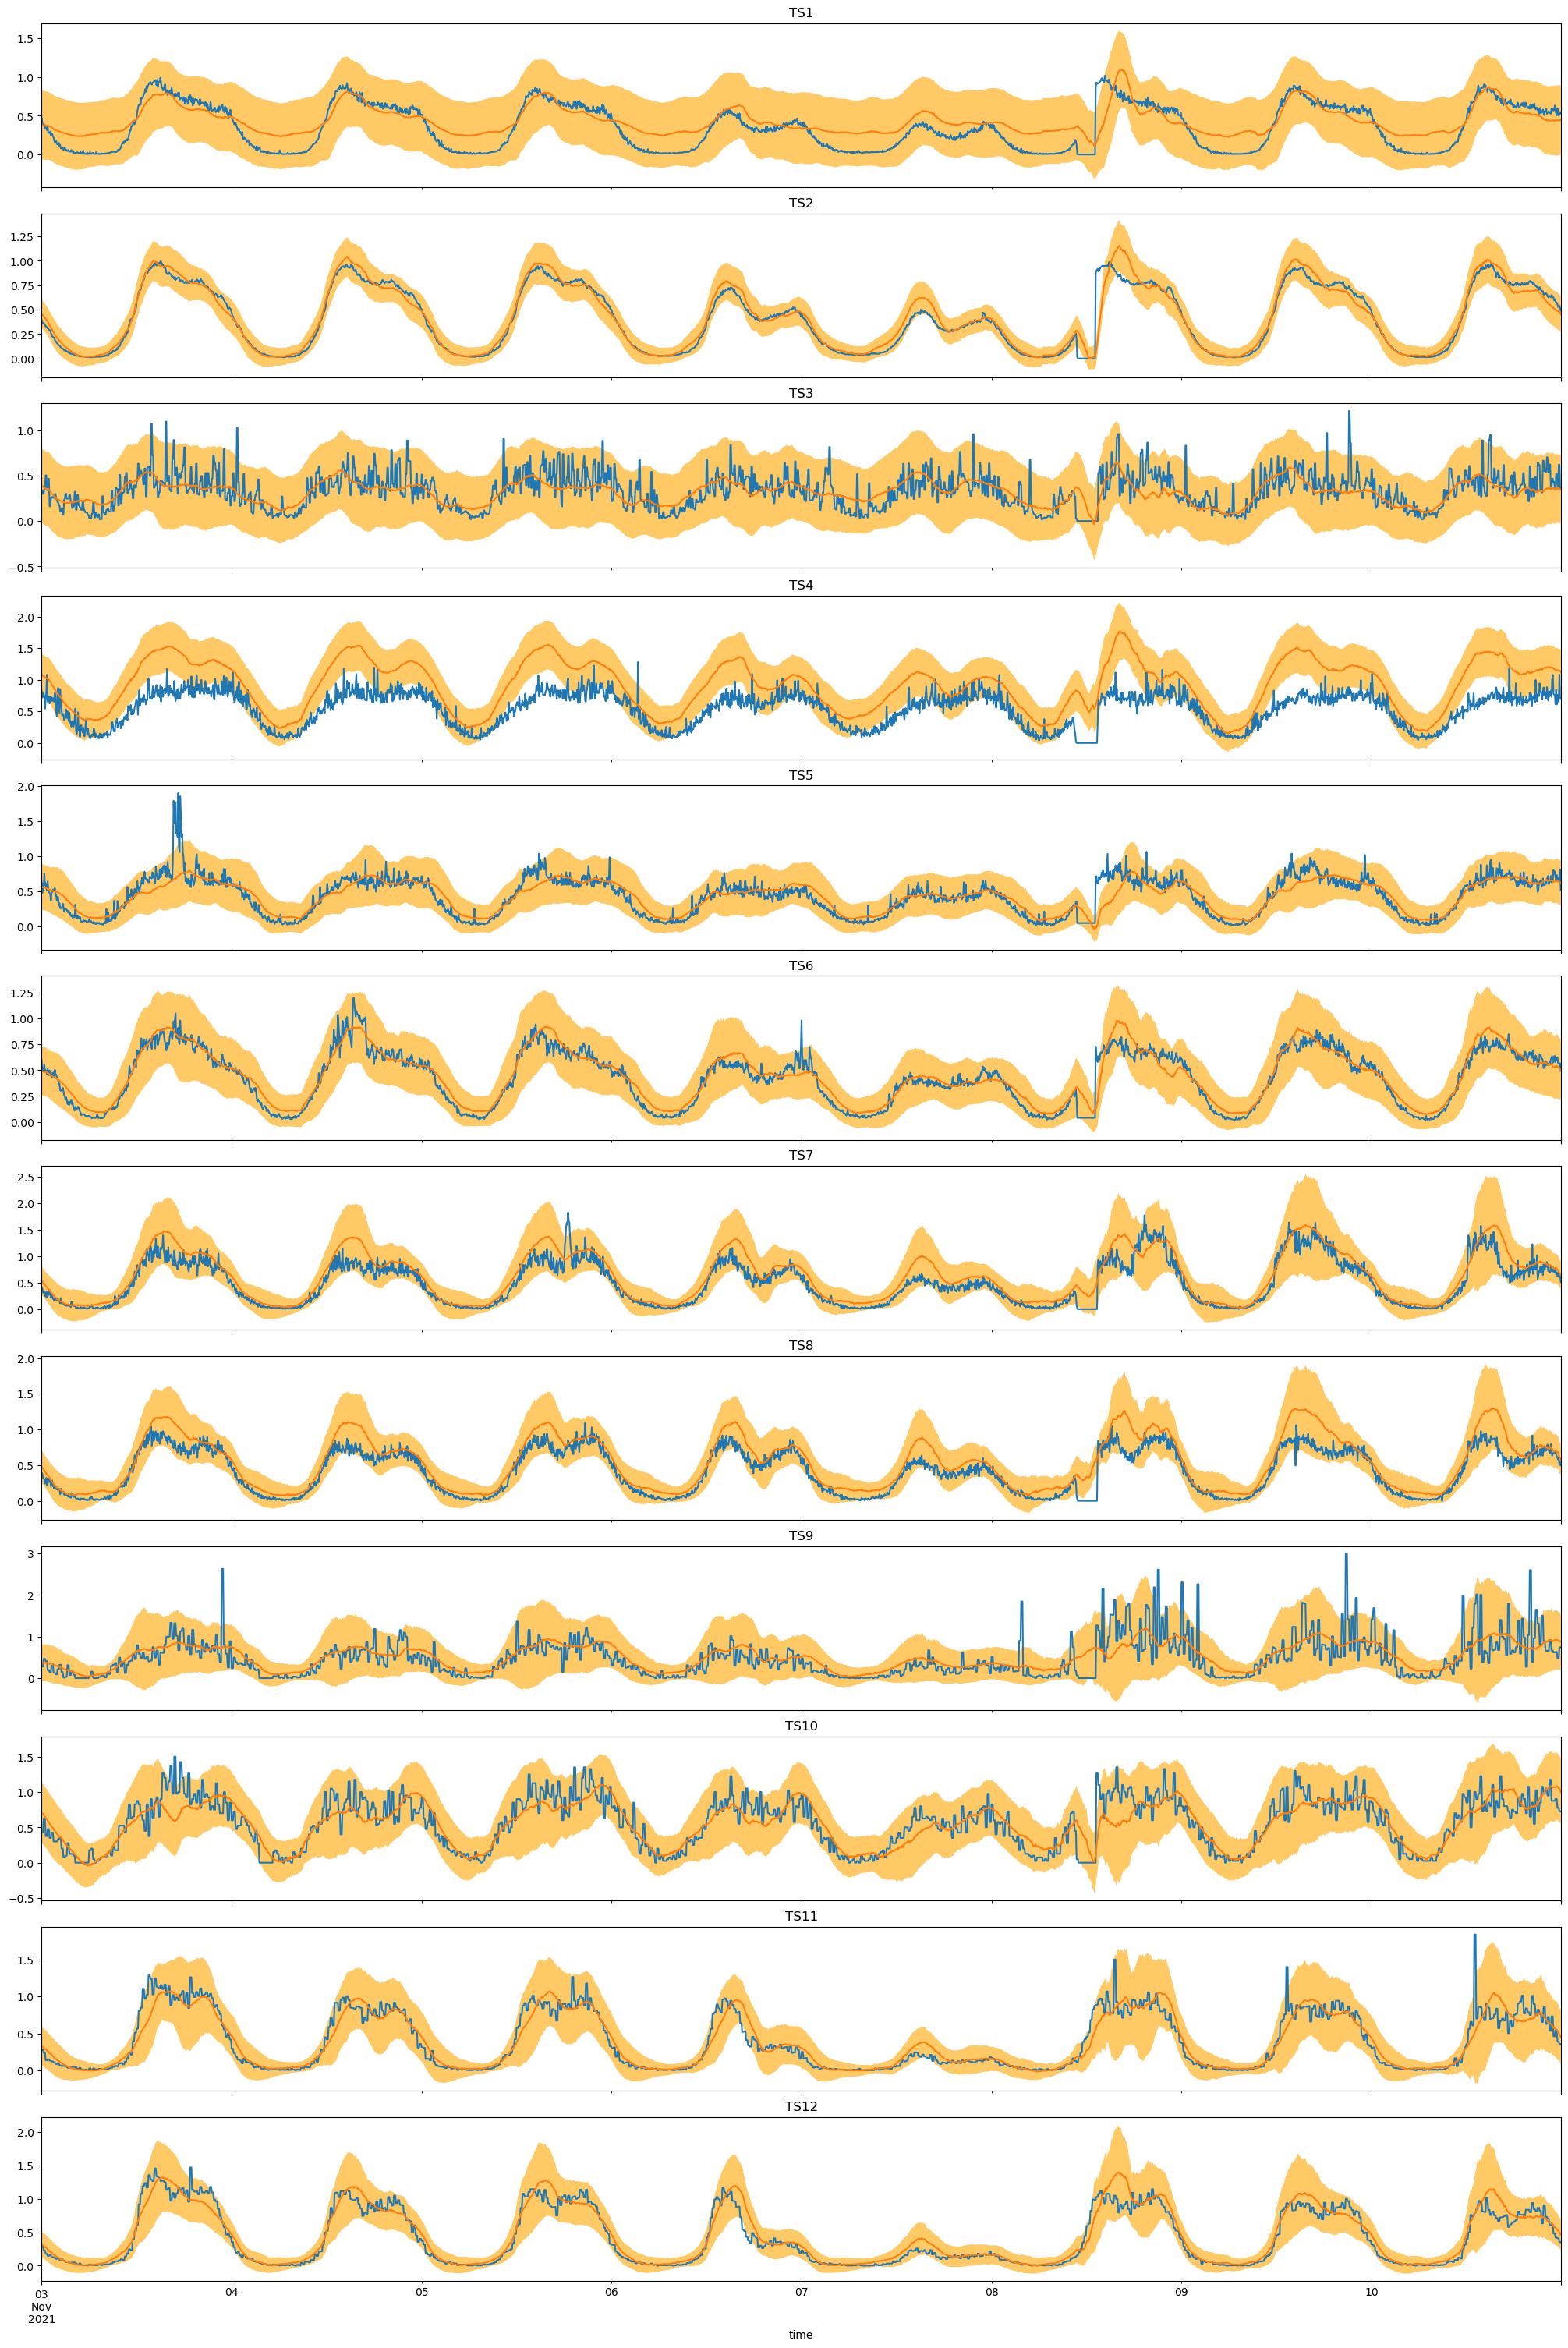

In [ ]:
#define number of rows and columns for subplots
nrow=12
ncol=1
data_aux = data_CD[reconst_CD.index[0]:].copy()

columns_list = data_aux.columns

time_start = '2021-11-03'
time_end = '2021-11-10'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_aux[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        reconst_CD[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].fill_between(data_aux[columns_list[count]][time_start:time_end].index,
                         th_up_CD[columns_list[count]][time_start:time_end],
                         th_down_CD[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.6, interpolate=True)
        axes[r].set_title(columns_list[count])
        count+=1

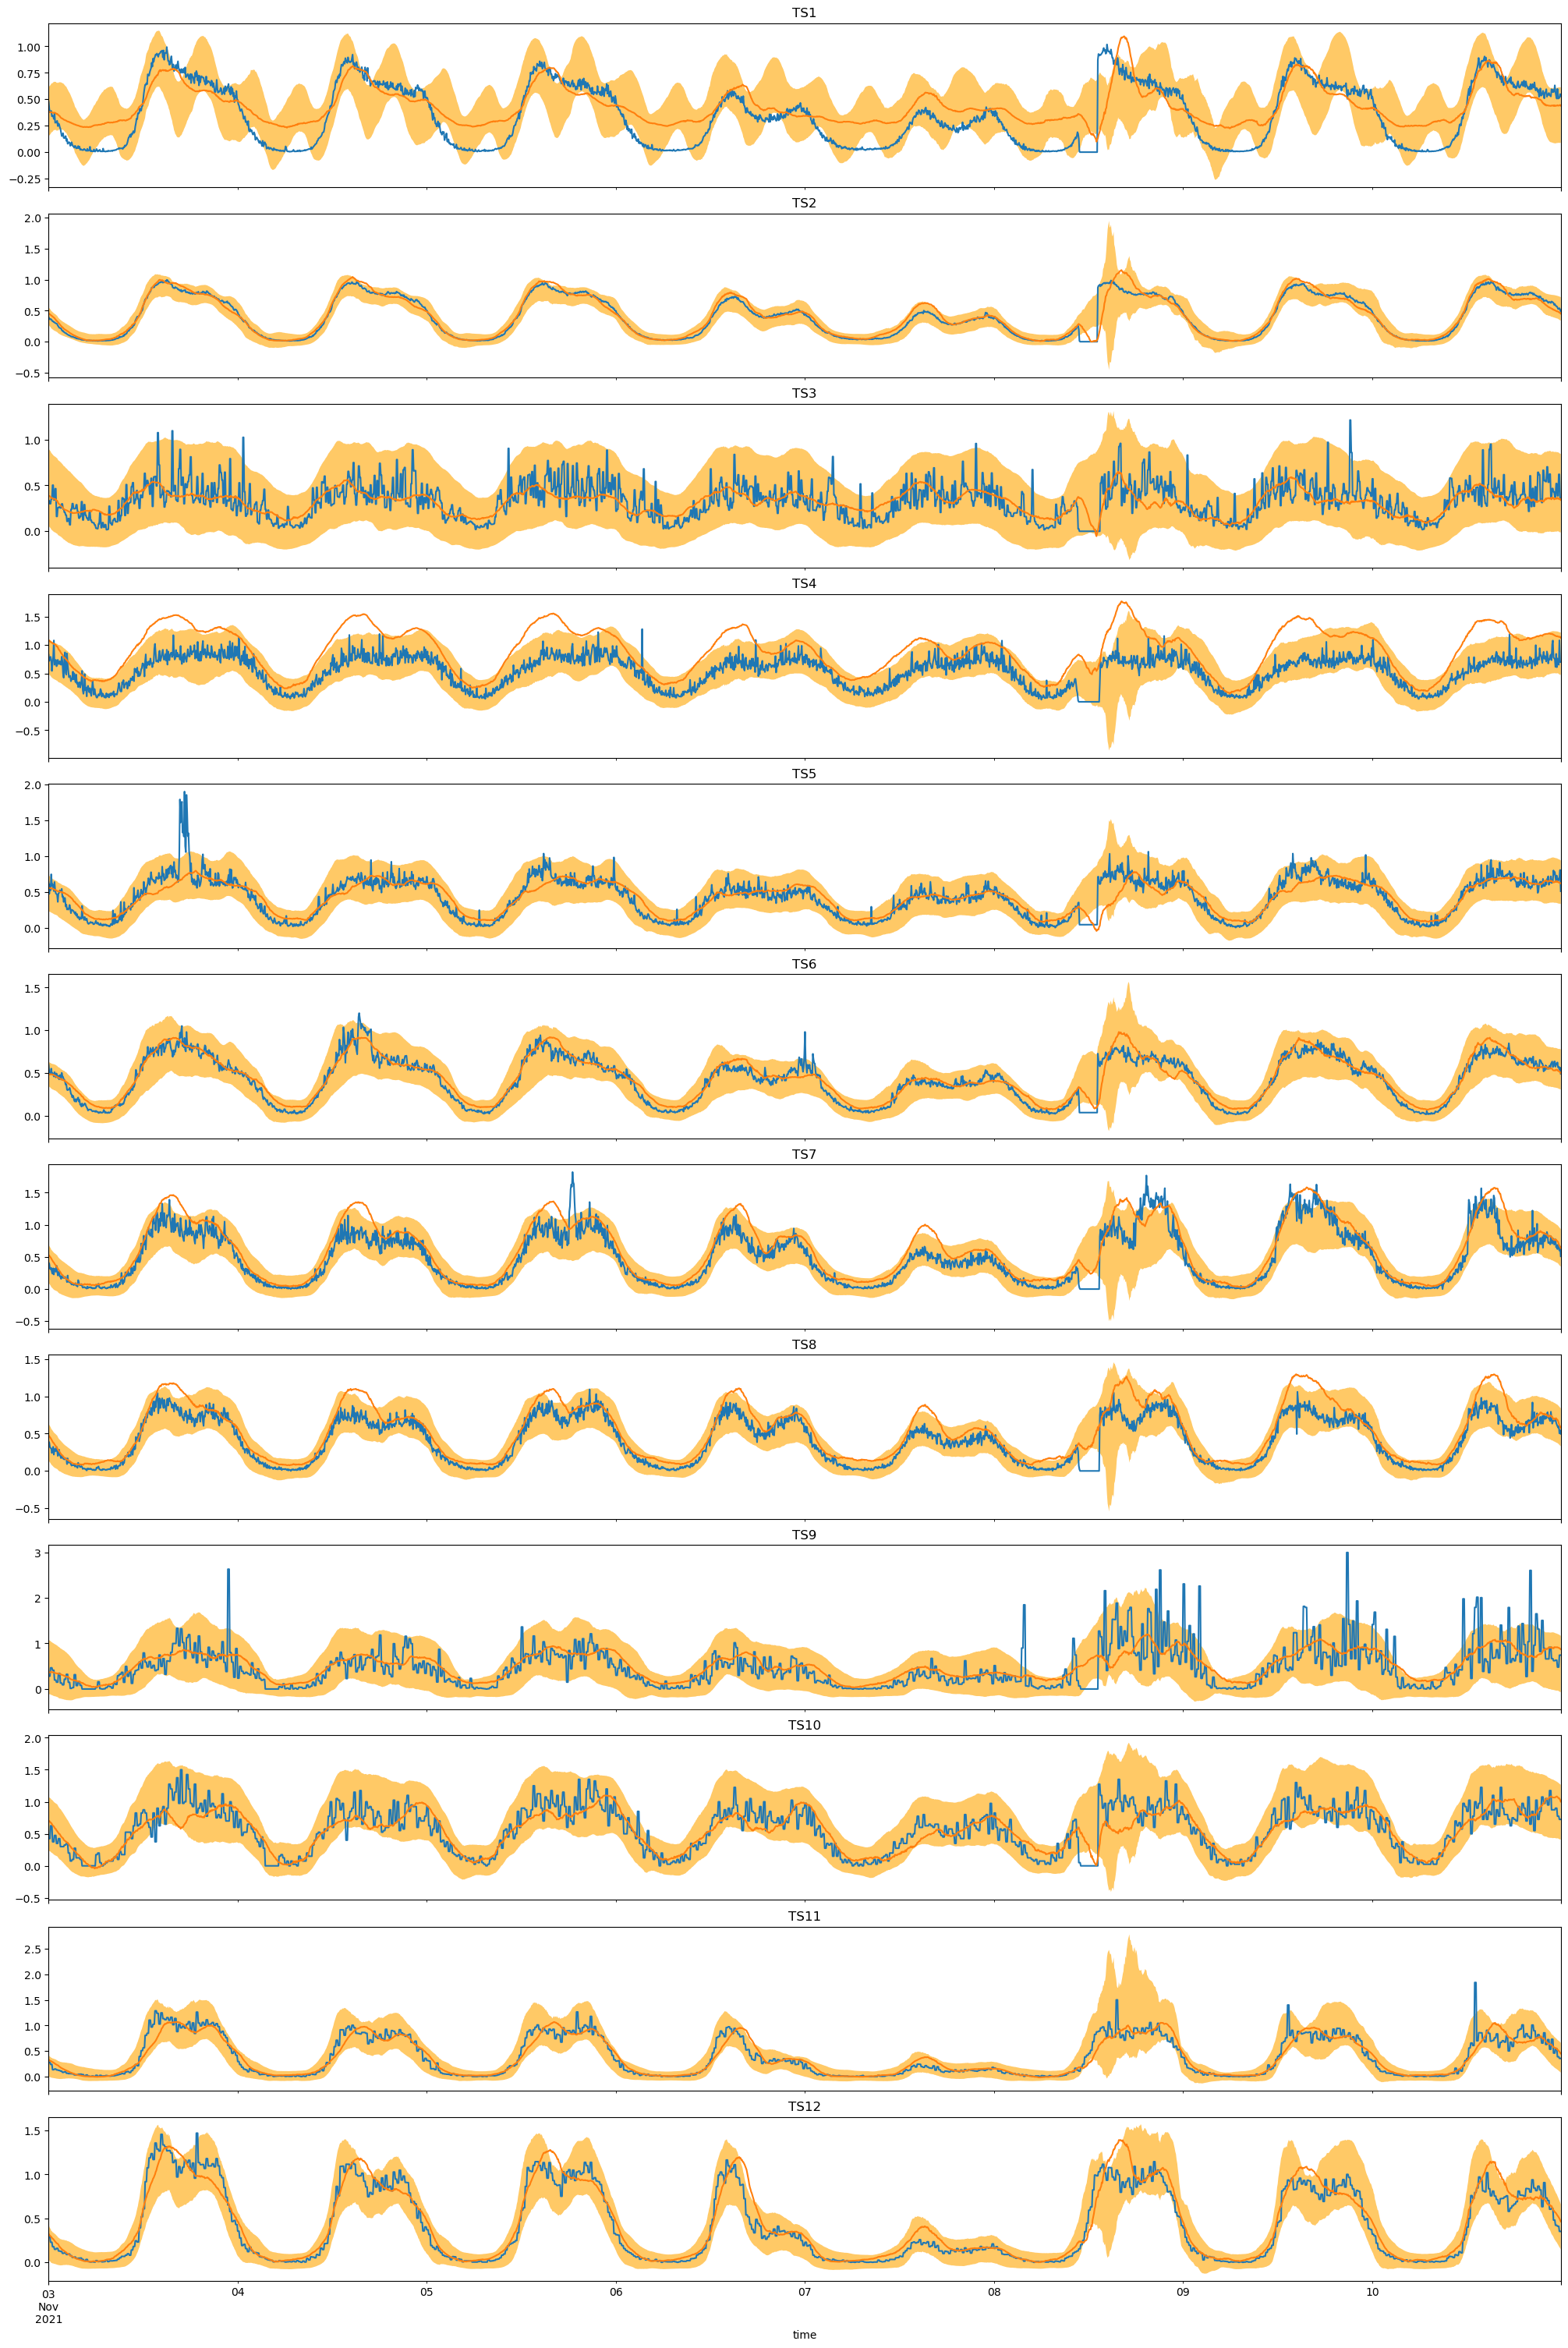

In [ ]:
#define number of rows and columns for subplots
nrow=12
ncol=1
data_aux = data_CD[reconst_CD.index[0]:].copy()

columns_list = data_aux.columns

time_start = '2021-11-03'
time_end = '2021-11-10'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_aux[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        reconst_CD[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].fill_between(data_aux[columns_list[count]][time_start:time_end].index,
                         th_up_CD[columns_list[count]][time_start:time_end],
                         th_down_CD[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.6, interpolate=True)
        axes[r].set_title(columns_list[count])
        count+=1

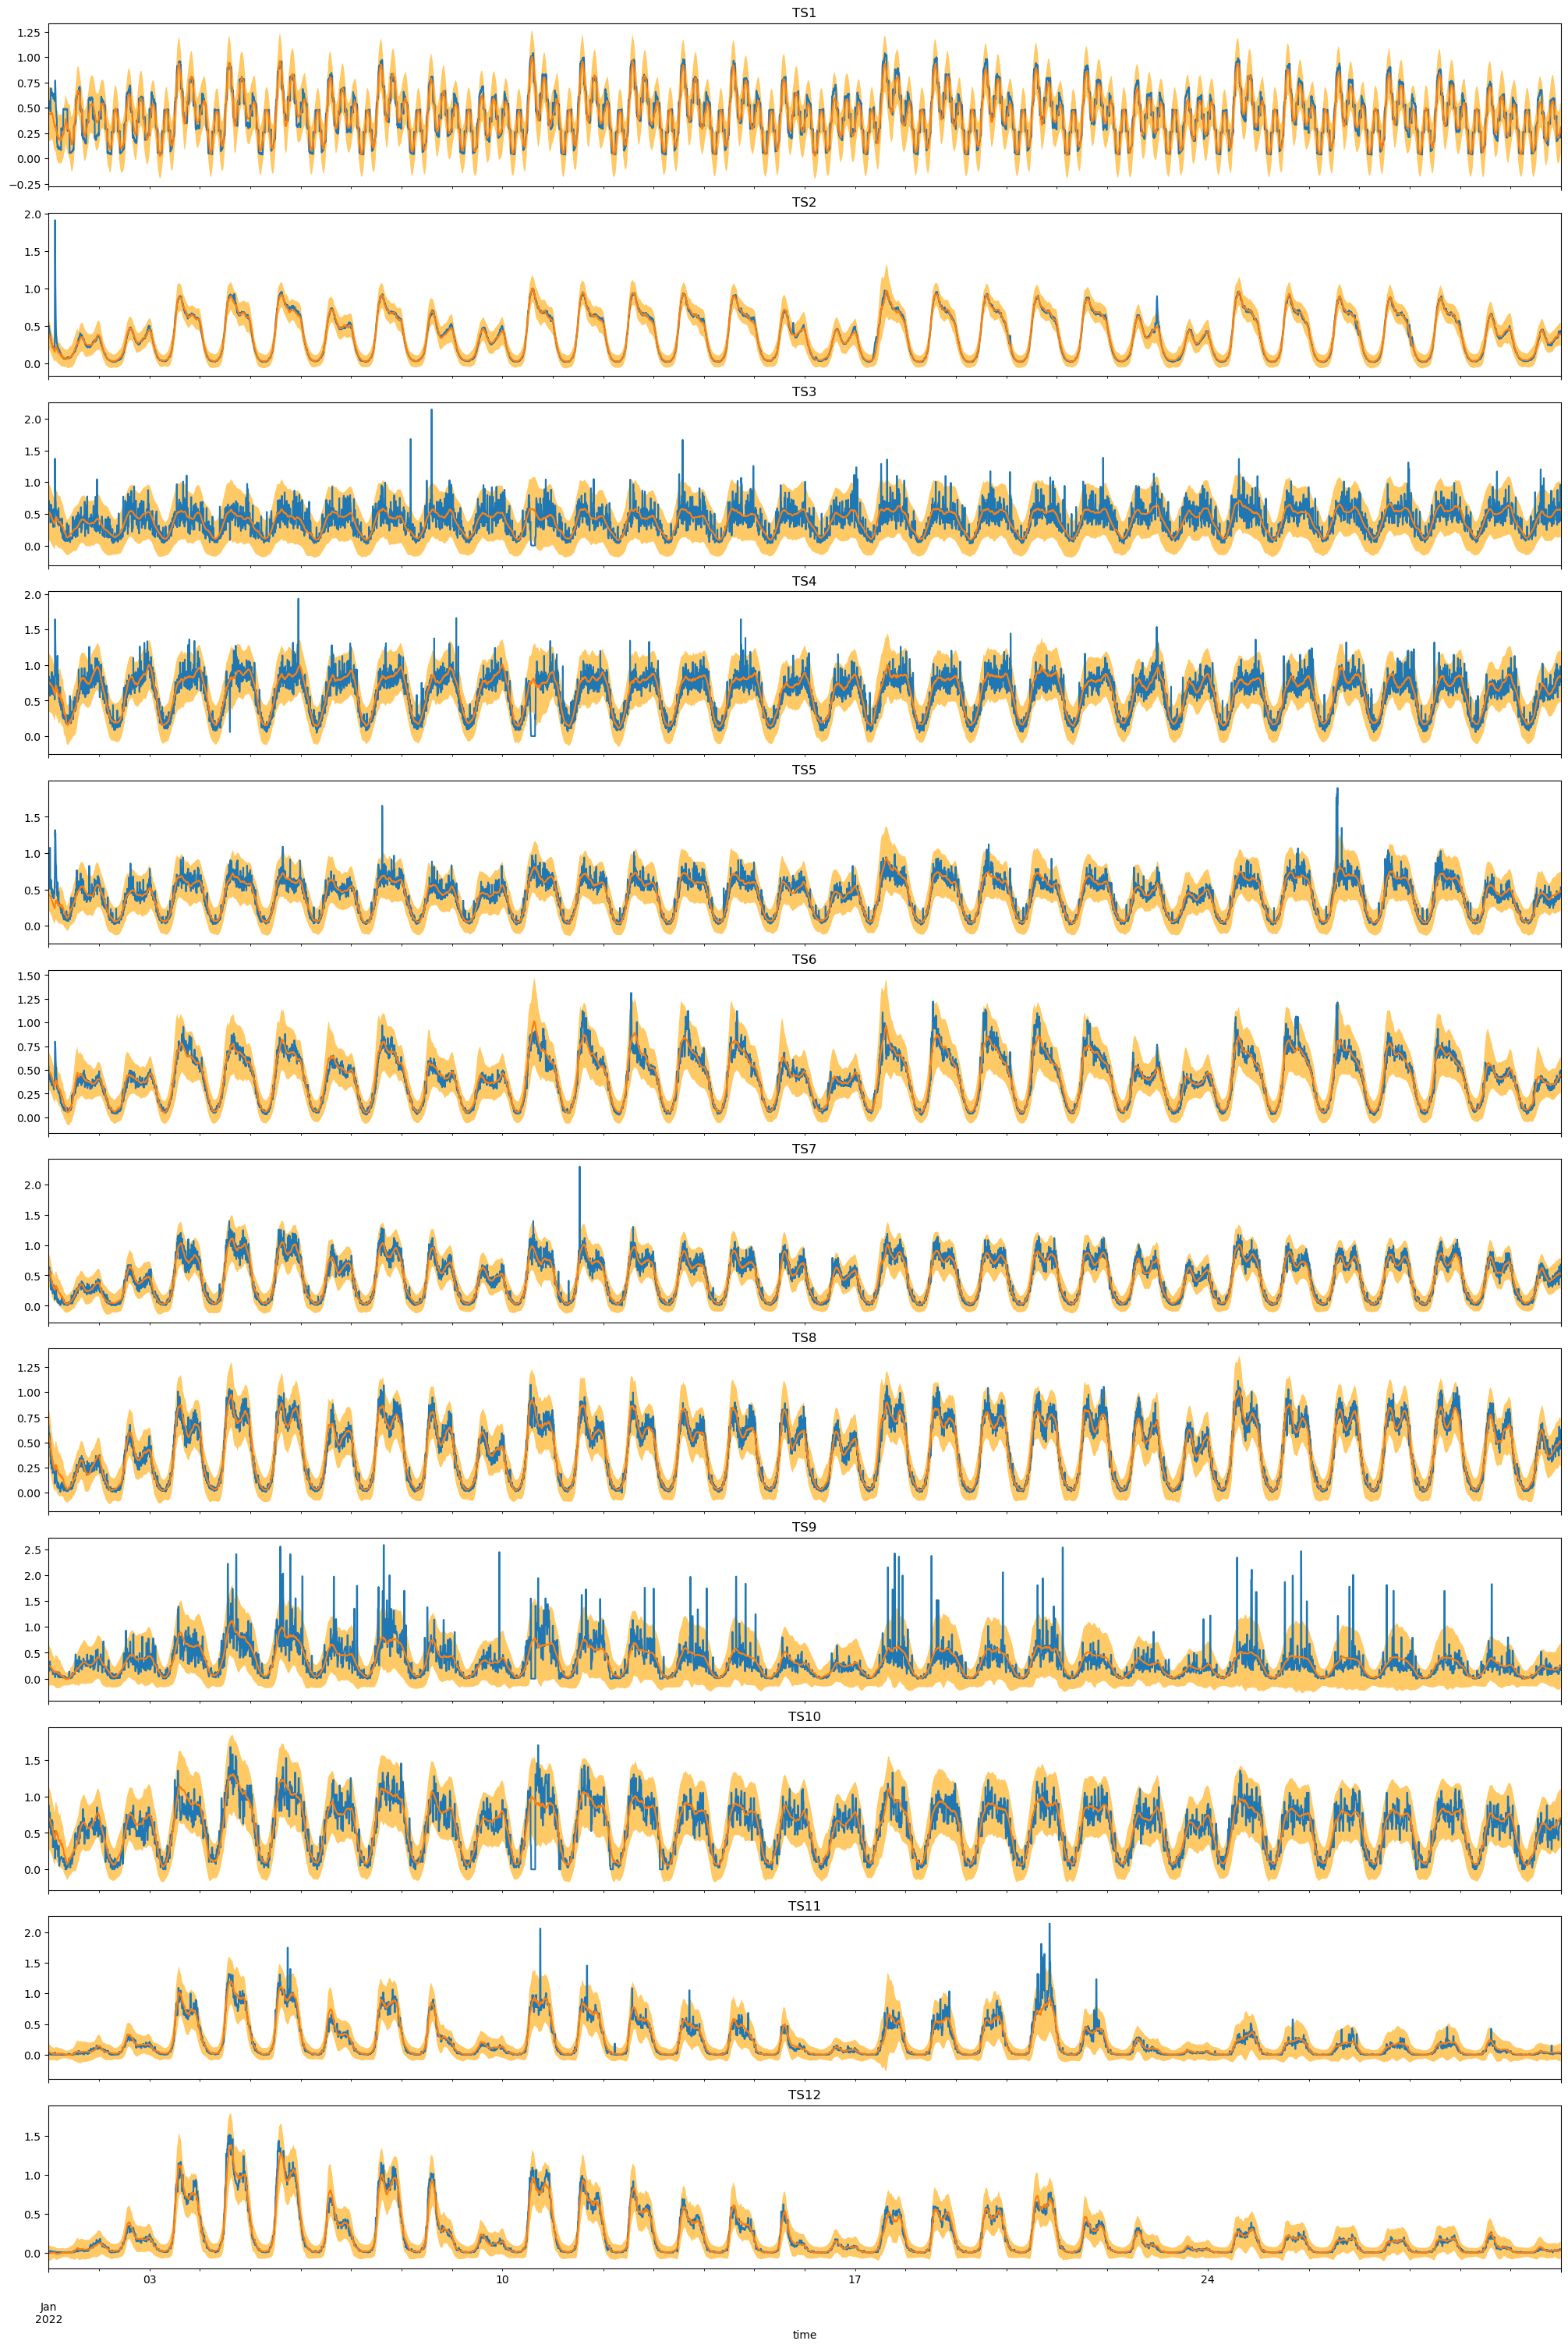

In [ ]:
#define number of rows and columns for subplots
nrow=12
ncol=1
data_aux = data_CD[reconst_CD.index[0]:].copy()

columns_list = data_aux.columns

time_start = '2022-01-01'
time_end = '2022-01-30'
fig, axes = plt.subplots(nrow, ncol, figsize=(20,30), constrained_layout=True, sharex=True)

# plot counter
count=0

for r in range(nrow):
    for c in range(ncol):
        data_aux[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        reconst_CD[columns_list[count]][time_start:time_end].plot(ax=axes[r])
        axes[r].fill_between(data_aux[columns_list[count]][time_start:time_end].index,
                         th_up_CD[columns_list[count]][time_start:time_end],
                         th_down_CD[columns_list[count]][time_start:time_end],
                         facecolor='orange', alpha=0.6, interpolate=True)
        axes[r].set_title(columns_list[count])
        count+=1